# Comparison of a simulated and a real trace of HPL

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
reality_archive = 'geometry/6/grenoble_2020-07-09_1939973.zip'
simgrid_archives = ['../smpi_hpl/geometry/18/grenoble_2020-07-09_1939976.zip']
sizes = list(read_csv(reality_archive, 'results.csv').matrix_size)
for archive in simgrid_archives:
    assert sizes == list(read_csv(archive, 'results.csv').matrix_size)
print(sizes)

[250000]


In [3]:
def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, exp_id, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    blas_trace = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    old_len = len(blas_trace)
   # blas_trace = blas_trace[(blas_trace['m'] != 0) & (blas_trace['n'] != 0) & (blas_trace['k'] != 0)]
    print('\tBLAS trace: %6d lines (removed %d lines with null sizes)' % (len(blas_trace), old_len - len(blas_trace)))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
#    blas_trace = blas_trace[['function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    df['duration'] = df['end'] - df['start']
    df['function'] = df['function'].str.strip()
    return df

traces = None
nbrow_limit = 2000000
for i, size in enumerate(sizes):
    print('Exp %d (matrix_size=%d)' % (i, size))
    for filename, mode in [(reality_archive, 'reality')] + [(archive, 'simgrid') for archive in simgrid_archives]:
        tmp_trace = read_archive(filename, mode, i)
        tmp_trace['matrix_size'] = size
        if len(tmp_trace) > nbrow_limit:
            sys.stderr.write('WARNING: dataframe for exp %d (matrix_size=%d) has %d rows, keeping %d' % (i, size, len(tmp_trace), nbrow_limit))
        tmp_trace = tmp_trace.head(n=nbrow_limit)
        if traces is not None:
            traces = pandas.concat([traces, tmp_trace])
        else:
            traces = tmp_trace

traces.head()

Exp 0 (matrix_size=250000)
# Mode: reality
	BLAS trace:  45784 lines (removed 0 lines with null sizes)
	MPI  trace:  64812 lines
Removed 31206 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace: 226218 lines (removed 0 lines with null sizes)
	MPI  trace:  23070 lines
Removed 960 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize


,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1,matrix_size
0,0.000000,4.103116,../HPL_pdtest.c,smpi_marker,NaN,BLAS,202.0,NaN,-1,NaN,0,4.103116,4.103116,reality,1,250000
1,0.000192,4.103359,../HPL_dlocmax.c,idamax,NaN,BLAS,125.0,250000.0,-1,NaN,0,4.103167,4.103167,reality,1,250000
2,0.000014,4.103377,../HPL_pdmxswp.c,dcopy,NaN,BLAS,165.0,128.0,-1,NaN,0,4.103363,4.103363,reality,1,250000
3,0.000003,4.103382,../HPL_pdmxswp.c,dcopy,NaN,BLAS,167.0,128.0,-1,NaN,0,4.103379,4.103379,reality,1,250000
4,0.000182,4.103570,../HPL_pdpancrT.c,dscal,NaN,BLAS,214.0,249999.0,-1,NaN,0,4.103388,4.103388,reality,1,250000


## HPL result

In [4]:
res = read_csv(reality_archive, 'results.csv')
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,250000,56.81


In [5]:
res = []
for archive in simgrid_archives:
    tmp = read_csv(archive, 'results.csv')
    res.append(tmp)
res = pandas.concat(res)
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,250000,30.96


## Checking the parameters

In [6]:
parameters = read_csv(simgrid_archives[0], 'exp_hpl.csv')
for archive in simgrid_archives:
    assert read_csv(archive, 'exp_hpl.csv').equals(parameters)
parameters

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,1,480,1,2,2,1,0,8,32,1


In [7]:
read_csv(reality_archive, 'exp_hpl.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,1,480,1,2,2,1,0,8,32,1


In [8]:
platforms = set([zipfile.ZipFile(archive).read('dahu.xml').decode('ascii') for archive in simgrid_archives])
assert len(platforms) == 1
print(platforms.pop())

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460

In [9]:
from IPython.display import display, Markdown
for archive in simgrid_archives:
    installfile = get_yaml(archive, 'info.yaml')['installfile']
    installfile_content = zipfile.ZipFile(archive).read(installfile).decode()
    display(Markdown('Archive name: %s' % archive))
    display(Markdown('```yaml\n%s\n```' % installfile_content))

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Archive name: ../smpi_hpl/geometry/18/grenoble_2020-07-09_1939976.zip

```yaml
trace_execution: True
terminate_early: True
insert_bcast: True
stochastic_network: True
stochastic_cpu: True
disable_hpl_kernels: False
disable_nondgemm_randomness: False
random_seed: 105

```

## Visualizing the trace

In [10]:
def split(df):
    '''
    For reasons I don't fully understand, the "elegant" implementation with list comprehension is *very* inneficient.
    I don't know if there is a more "pythonic" approach than this one, which seems pretty ugly to me but works fine.
    '''
    all_ranks = list(df['rank'].unique())
    all_sizes = list(df['matrix_size'].unique())
    all_modes = list(df['mode'].unique())
    all_kinds = list(df['kind'].unique())
    all_df = []
    for rank in all_ranks:
        tmp_rank = df[df['rank'] == rank]
        for matrix_size in all_sizes:
            tmp_size = tmp_rank[tmp_rank['matrix_size'] == matrix_size]
            for mode in all_modes:
                tmp_mode = tmp_size[tmp_size['mode'] == mode]
                for kind in all_kinds:
                    all_df.append(tmp_mode[tmp_mode['kind'] == kind])
    return all_df

def crop(df):
    kind = list(df['kind'].unique())
    assert len(kind) == 1
    kind = kind[0]
    if kind == 'BLAS':
        func_calls = df[df['function'] == 'smpi_marker']
    else:
        assert kind == 'MPI'
        func_calls = df[df['function'] == 'MPI_Bcast']
    assert len(func_calls) == 2
    start = func_calls['end'].min()
    end = func_calls['start'].max()
    df = df[(df['start'] > start) & (df['end'] < end)].copy()
    min_time = df['start'].min()
    df['start'] -= min_time
    df['end'] -= min_time
    return df

def crop_all(df):
    df_split = [crop(tmp_df) for tmp_df in split(df)]
    return pandas.concat(df_split)

traces = crop_all(traces)

In [11]:
traces['func'] = traces['function']
traces.loc[~traces['function'].isin(['dgemm', 'dtrsm', 'MPI_Send', 'MPI_Recv']), 'func'] = 'other'

In [12]:
def plot(df, wrap=None, lines=[], hard_lines=False):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='func')) + theme_bw()
    if wrap:
        gc = gc + facet_wrap(wrap, labeller='label_both', ncol=2)
        guide = False
    else:
        guide = 'legend'
    gc = gc + scale_fill_brewer(type='qualitative', palette='Dark2', guide=guide)
    if lines:
        gc = gc + scale_x_continuous(breaks = lines) + expand_limits(x=max(lines))
        if hard_lines:
            for line in lines:
                gc = gc + geom_vline(xintercept=line, linetype='dashed', alpha=0.5)
    return gc

def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

def my_range(start, stop, nb_steps):
    interval = (stop-start)/(nb_steps+1)
    val = start
    result = []
    for _ in range(nb_steps+2):
        result.append(val)
        val += interval
    return result

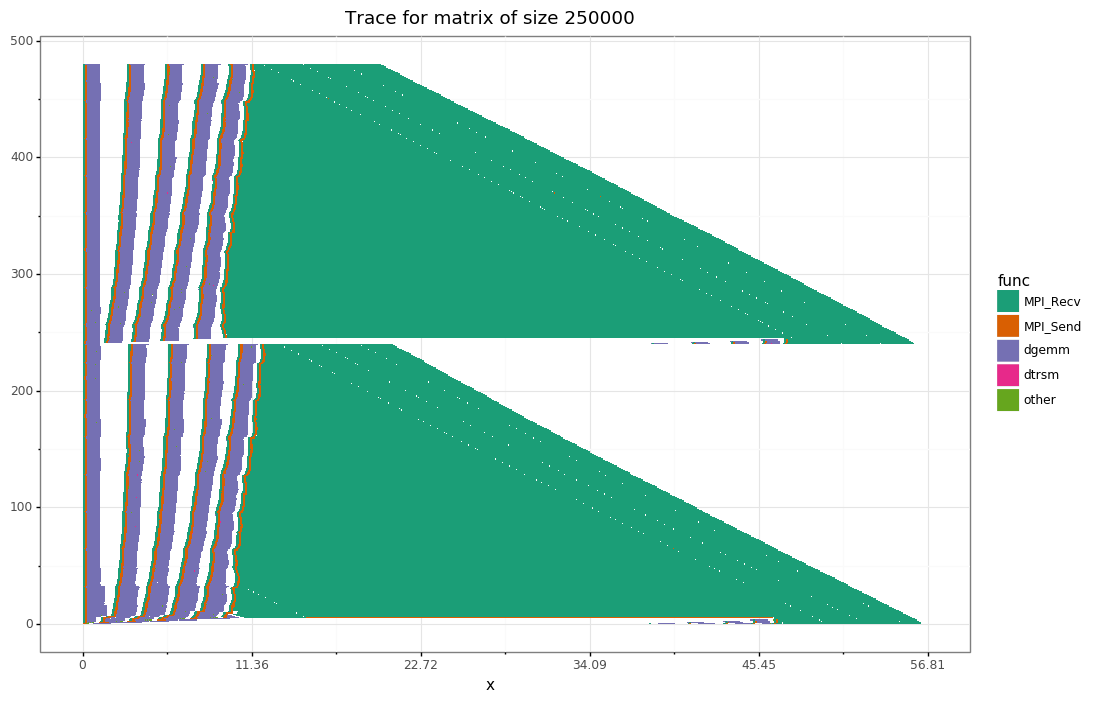

<ggplot: (8789223822179)>


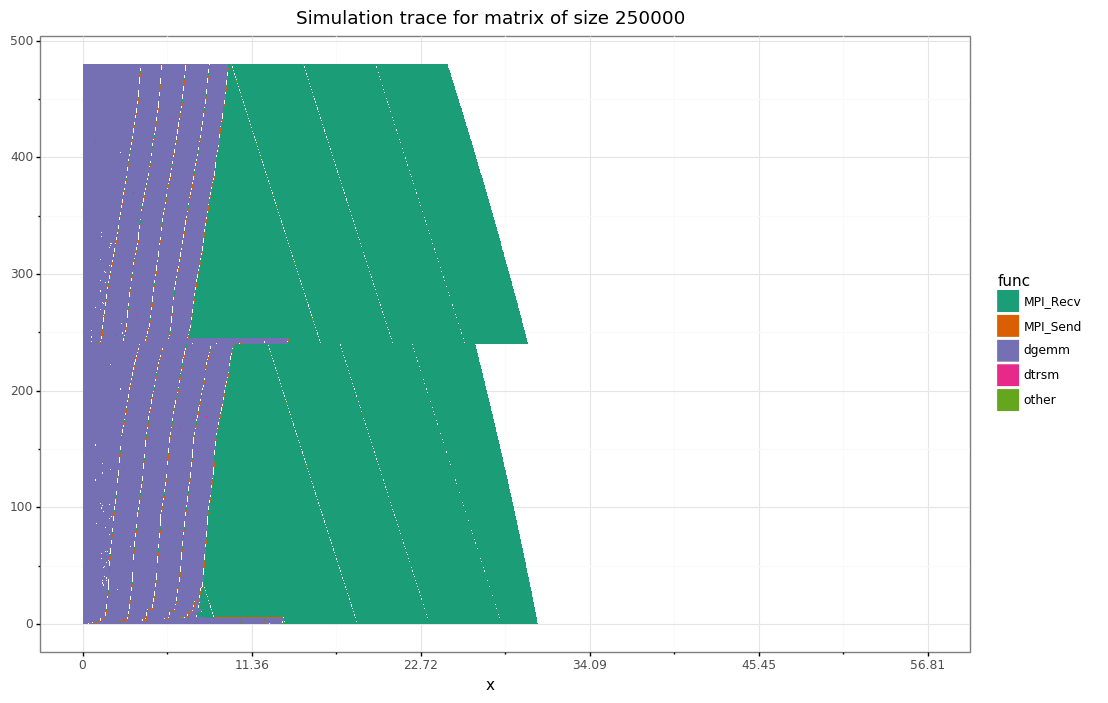

<ggplot: (8789211499279)>


In [13]:
for size in sorted(traces.matrix_size.unique()):
    tmp = traces[(traces['matrix_size'] == size)]
    lines = my_range(tmp.start.min(), tmp.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size))
    print(plot(tmp[tmp['mode'] != 'reality'], lines=lines) + ggtitle('Simulation trace for matrix of size %d' % size))

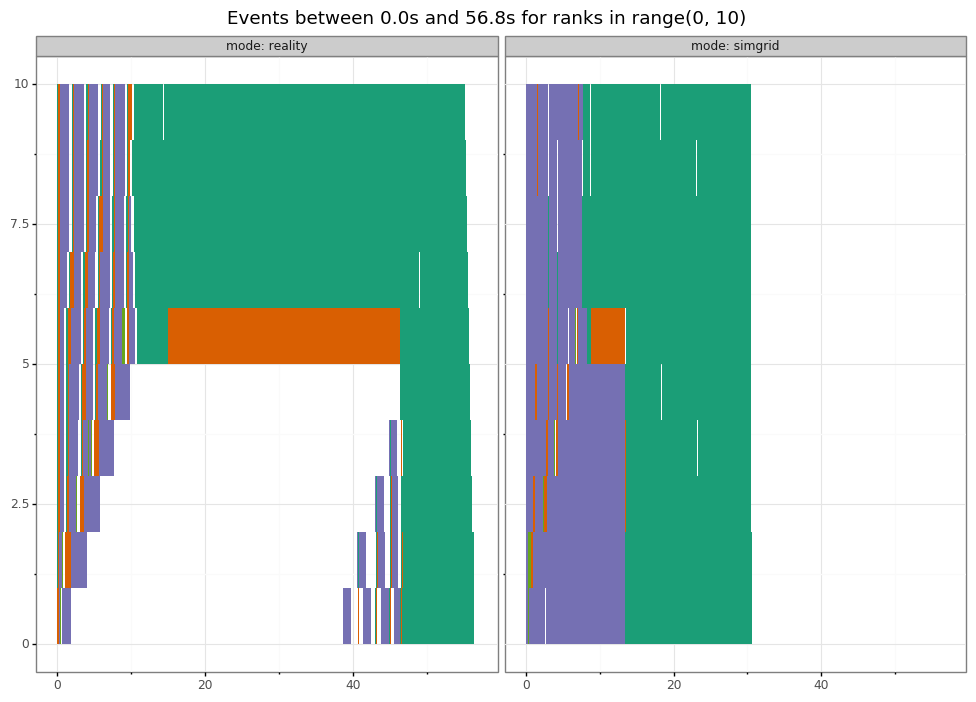

<ggplot: (-9223363247630893017)>

In [14]:
plot_bounded(traces, 0, traces.end.max(), range(10), wrap=['mode'])

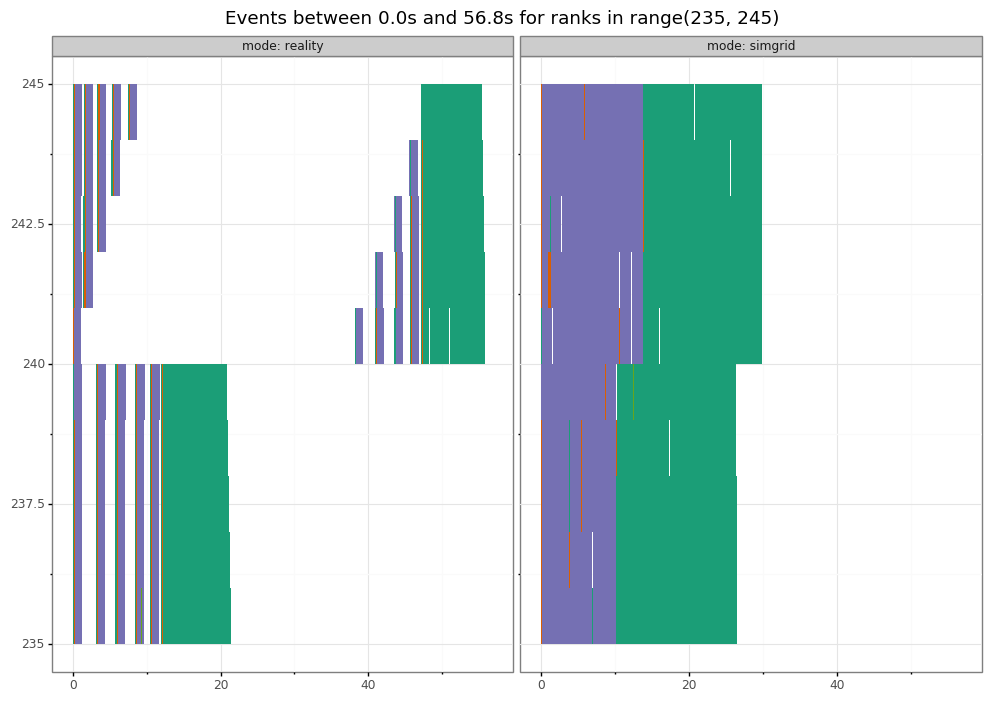

<ggplot: (8789211564029)>

In [15]:
plot_bounded(traces, 0, traces.end.max(), range(235, 245), wrap=['mode'])

Let's have a look at this `MPI_Send` from rank 5. First, is it a single call to the function, or several? What is the message size?

In [16]:
traces[(traces['rank'] == 5) & (traces['start'] > 10) & (traces['end'] < 50) & (traces['mode'] == 'reality')].sort_values(by='start')[['file', 'line', 'start', 'end', 'function', 'rank', 'duration', 'msg_size']]

,file,line,start,end,function,rank,duration,msg_size
7328,NaN,NaN,10.843126,15.002740,MPI_Recv,5,4.159614e+00,490496
42007,../HPL_pdtrsv.c,248.0,14.698340,14.698426,daxpy,5,8.573100e-05,-1
42008,../HPL_pdtrsv.c,257.0,14.698430,14.698468,dtrsv,5,3.768500e-05,-1
42009,../HPL_pdtrsv.c,258.0,14.698470,14.698474,dcopy,5,4.358000e-06,-1
42010,../HPL_pdtrsv.c,226.0,14.698470,14.704141,dgemv,5,5.670610e-03,-1
7329,NaN,NaN,15.008552,46.413432,MPI_Send,5,3.140488e+01,490496
42011,../HPL_pdtrsv.c,265.0,46.109030,46.125668,dgemv,5,1.663828e-02,-1
7330,NaN,NaN,46.430080,49.190440,MPI_Recv,5,2.760360e+00,490496
42012,../HPL_pdtrsv.c,248.0,48.886040,48.886112,daxpy,5,7.196800e-05,-1
42013,../HPL_pdtrsv.c,257.0,48.886110,48.886138,dtrsv,5,2.799000e-05,-1


In [17]:
evt = traces[(traces['rank'] == 5) & (traces['start'] > 15) & (traces['start'] < 16) & (traces['mode'] == 'reality') & (traces['function'] == 'MPI_Send')]
assert len(evt) == 1
evt_start = evt.iloc[0].start
evt_end = evt.iloc[0].end
evt_size = evt.iloc[0].msg_size
print(evt_start, evt_end, evt_size)
evt

15.008552 46.41343200000001 490496


,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1,matrix_size,func
7329,31.40488,46.413432,NaN,MPI_Send,NaN,MPI,NaN,NaN,490496,NaN,5,15.008552,NaN,reality,6,250000,MPI_Send


Ok, this is a single call with a message of about 490kB and a duration of 31 seconds. This is very probably **not** a network issue, but rather the receiver which has a huge delay before receiving the message. Let's try to find out who is the likely culprit. We cannot be too tight on the time bounds, as the clocks of the nodes are not perfectly synchronized.

Let's add an extremly conservative bound on the duration (considering that this MPI_Recv should not block, as the corresponding MPI_Send was done a while ago).

In [18]:
duration_bound = evt_size / 1e6 + 0.1  # bandwidth of at least 1MB/s and latency of at most 0.1s
duration_bound

0.590496

In [19]:
traces[(traces['start'] > evt_end-1.5) &   # the MPI_Recv probably started at most 1s before the MPI_Send terminated
       (traces['start'] < evt_end+0.5) &     # the MPI_Recv cannot start after the MPI_Send has terminated
       (traces['end'] < evt_end+2) &     # the MPI_Recv cannot terminate too much after the MPI_Send
       (traces['mode'] == 'reality') & (traces['function'] == 'MPI_Recv') & # quite obvious
       (traces['msg_size'] == evt_size) & # the message size must be the same
       (traces['duration'] < duration_bound)
      ].sort_values(by='start')[['start', 'end', 'function', 'rank', 'duration', 'msg_size']]

,start,end,function,rank,duration,msg_size
19565,46.567422,46.567707,MPI_Recv,4,0.000285,490496
64646,46.622317,47.023643,MPI_Recv,0,0.401326,490496
34539,46.717620,46.723770,MPI_Recv,3,0.006150,490496
49503,46.733543,46.870719,MPI_Recv,2,0.137176,490496
64449,46.748351,47.017448,MPI_Recv,1,0.269097,490496


Now, let's try the same thing with the simulated data. Here the clocks **are** synchronized, so we can be much tighter. Hopefully the communication pattern will be exactly the same (this might not be true, since there is some randomness in HPL).

In [20]:
traces[(traces['rank'] == 5) & (traces['start'] > 8) & (traces['end'] < 14) & (traces['mode'] == 'simgrid')].sort_values(by='start')[['file', 'line', 'start', 'end', 'function', 'rank', 'duration', 'msg_size']]

,file,line,start,end,function,rank,duration,msg_size
2118,NaN,NaN,8.249424,8.813725,MPI_Recv,5,5.643010e-01,490496
206133,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,248.0,8.783630,8.783631,daxpy,5,3.930000e-07,-1
206134,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,257.0,8.783630,8.783649,dtrsv,5,1.900500e-05,-1
206135,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,258.0,8.783649,8.783649,dcopy,5,1.000000e-08,-1
206136,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,226.0,8.783649,8.793673,dgemv,5,1.002341e-02,-1
2119,NaN,NaN,8.823768,13.480065,MPI_Send,5,4.656297e+00,490496
206137,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,265.0,13.449967,13.479760,dgemv,5,2.979243e-02,-1


In [21]:
evt = traces[(traces['rank'] == 5) & (traces['start'] > 8.8) & (traces['start'] < 9) & (traces['mode'] == 'simgrid') & (traces['function'] == 'MPI_Send')]
assert len(evt) == 1
evt_start = evt.iloc[0].start
evt_end = evt.iloc[0].end
evt_size = evt.iloc[0].msg_size
print(evt_start, evt_end, evt_size)
evt

8.823768 13.480065000000002 490496


,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1,matrix_size,func
2119,4.656297,13.480065,NaN,MPI_Send,NaN,MPI,NaN,NaN,490496,NaN,5,8.823768,NaN,simgrid,6,250000,MPI_Send


In [22]:
traces[(traces['start'] > evt_end-1.5) &   # the MPI_Recv probably started at most 1s before the MPI_Send terminated
       (traces['start'] <= evt_end+0.5) &      # the MPI_Recv cannot start after the MPI_Send has terminated
       (traces['end'] < evt_end+2) &       # the MPI_Recv cannot terminate too much after the MPI_Send
       (traces['mode'] == 'simgrid') & (traces['function'] == 'MPI_Recv') & # quite obvious
       (traces['msg_size'] == evt_size) & # the message size must be the same
       (traces['duration'] < duration_bound)
      ].sort_values(by='start')[['start', 'end', 'function', 'rank', 'duration', 'msg_size']]

,start,end,function,rank,duration,msg_size
23041,13.469032,13.586568,MPI_Recv,0,0.117536,490496
17648,13.484738,13.570864,MPI_Recv,1,0.086126,490496
2631,13.495358,13.495396,MPI_Recv,4,0.000038,490496
12327,13.501106,13.545300,MPI_Recv,2,0.044194,490496
7003,13.510090,13.520240,MPI_Recv,3,0.010150,490496


In both case, the most likely corresponding call to `MPI_Recv` is done by a rank in {0,1,2,3,4}. Looking at the Gantt chart, the rank 4 is even more suspicious as it has **no** reported activity before this `MPI_Recv` (the other four ranks have a long "idle" period, but they perform some calls to `dgemm` just before).

Now the question is, what is this idle period? What the hell is happening on this rank?

In [23]:
traces[(traces['rank'] == 4) & (traces['start'] > 9.56) & (traces['end'] < 47) & (traces['mode'] == 'reality')].sort_values(by='start')[['file', 'line', 'start', 'end', 'function', 'rank', 'duration', 'msg_size', 'm', 'n', 'k']]

,file,line,start,end,function,rank,duration,msg_size,m,n,k
40264,NaN,0.0,9.569439,9.569947,HPL_dlaswp00N,4,0.000508,-1,128.0,128.0,NaN
40265,../HPL_pdupdateTT.c,184.0,9.569949,9.570130,dtrsm,4,0.000181,-1,128.0,128.0,NaN
40266,../HPL_pdupdateTT.c,202.0,9.570129,9.884928,dgemm,4,0.314799,-1,249360.0,128.0,128.0
40267,../HPL_pdtrsv.c,248.0,46.263309,46.263359,daxpy,4,0.000050,-1,61312.0,NaN,NaN
40268,../HPL_pdtrsv.c,257.0,46.263369,46.263436,dtrsv,4,0.000067,-1,128.0,NaN,NaN
40269,../HPL_pdtrsv.c,258.0,46.263439,46.263442,dcopy,4,0.000003,-1,128.0,NaN,NaN
40270,../HPL_pdtrsv.c,226.0,46.263439,46.268882,dgemv,4,0.005443,-1,61312.0,128.0,NaN
40271,../HPL_pdtrsv.c,265.0,46.269159,46.286383,dgemv,4,0.017224,-1,184960.0,128.0,NaN
19564,NaN,NaN,46.441386,46.566378,MPI_Recv,4,0.124992,255345672,NaN,NaN,NaN
19565,NaN,NaN,46.567422,46.567707,MPI_Recv,4,0.000285,490496,NaN,NaN,NaN


In [24]:
traces[(traces['rank'] == 4) & (traces['start'] > 7.83) & (traces['end'] < 14) & (traces['mode'] == 'simgrid')].sort_values(by='start')[['file', 'line', 'start', 'end', 'function', 'rank', 'duration', 'msg_size', 'm', 'n', 'k']]

,file,line,start,end,function,rank,duration,msg_size,m,n,k
198402,NaN,0.0,7.836028,7.836028,HPL_dlaswp00N,4,1.000000e-08,-1,128.0,128.0,NaN
198403,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,184.0,7.836028,7.836140,dtrsm,4,1.126300e-04,-1,128.0,128.0,NaN
198404,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,202.0,7.836141,8.130793,dgemm,4,2.946525e-01,-1,249360.0,128.0,128.0
198405,NaN,0.0,8.130794,8.130794,HPL_dlaswp00N,4,1.000000e-08,-1,128.0,0.0,NaN
198406,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,184.0,8.130794,8.130794,dtrsm,4,1.000000e-08,-1,128.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
199167,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,226.0,13.464446,13.474499,dgemv,4,1.005312e-02,-1,61312.0,128.0,NaN
199168,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,265.0,13.474546,13.504913,dgemv,4,3.036728e-02,-1,184960.0,128.0,NaN
2630,NaN,NaN,13.480999,13.495358,MPI_Recv,4,1.435900e-02,255345672,NaN,NaN,NaN
2631,NaN,NaN,13.495358,13.495396,MPI_Recv,4,3.800000e-05,490496,NaN,NaN,NaN


So, both in reality and in simulation, this rank does:
- a few very short BLAS functions in `HPL_pdupdateTT`
- an extremly long blank period
- a few very short BLAS functions in `HPL_pdtrsv`
- the call to `MPI_Recv` which (probably) un-block the very long `MPI_Send` posted by rank 5

## Plotting the total time spent in each function

In [25]:
def plot_total_duration(df, function):
    df = df[df.function == function][['rank', 'mode', 'start', 'end', 'duration', 'matrix_size']]
    df = df.groupby(['rank', 'mode', 'matrix_size']).sum().reset_index()
    plot = ggplot(df, aes(x='rank', y='duration', color='factor(mode)')) + geom_point() + theme_bw() + expand_limits(y=0) + ggtitle('Total time spent in function %s' % function)
    plot = plot + facet_wrap('matrix_size', scales='free') + theme(subplots_adjust={'wspace':0.20})
    print(plot)
####################################################
    return  # not plotting the differencep plot
    modes = list(df['mode'].unique())
    if len(modes) != 2:
        return
    df1 = df[df['mode'] == modes[0]]
    df2 = df[df['mode'] == modes[1]]
    df = df1.set_index('rank').join(df2.set_index('rank'), rsuffix='_simgrid').reset_index()
    df['difference'] = (df['duration_simgrid'] - df['duration'])/df['duration'] * 100
    max_point = df[df.difference.abs() == df.difference.abs().max()]
    max_rank = list(max_point['rank'])[0]
    max_diff = list(max_point['difference'])[0]
    plot = ggplot(df, aes(x='rank', y='difference')) + geom_point() + theme_bw() + ggtitle('Difference in the total time spent in function %s' % function)
    plot = plot + ylab('duration difference (%)') + geom_hline(yintercept=0, color='red')
    ranks = list(df['rank'])
    mid_rank = (max(ranks) + min(ranks)) / 2
    shift = -1 if max_rank > mid_rank else +1
    plot = plot + annotate('text', label='rank %d, error of %.2f%%' % (max_rank, max_diff), x=max_rank+shift*2, y=max_diff*1.05) + annotate('segment', x=max_rank+shift, y=max_diff*1.05, xend=max_rank, yend=max_diff, size=0.5)
    print(plot)

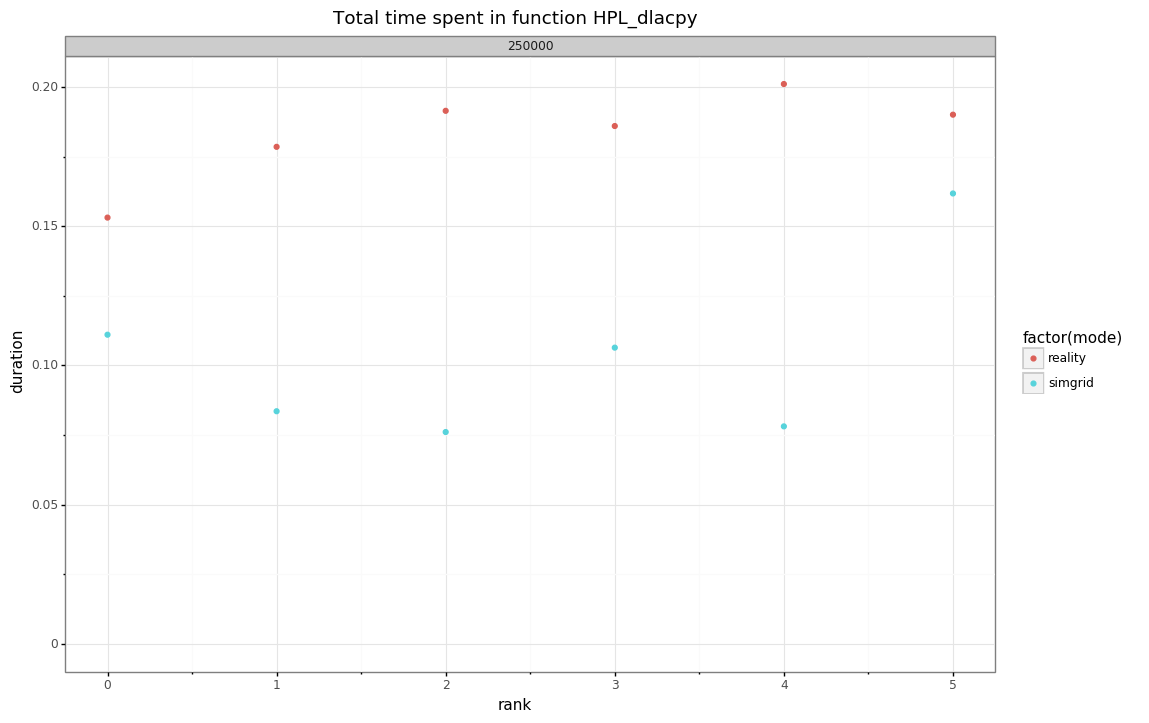

<ggplot: (8789212062952)>


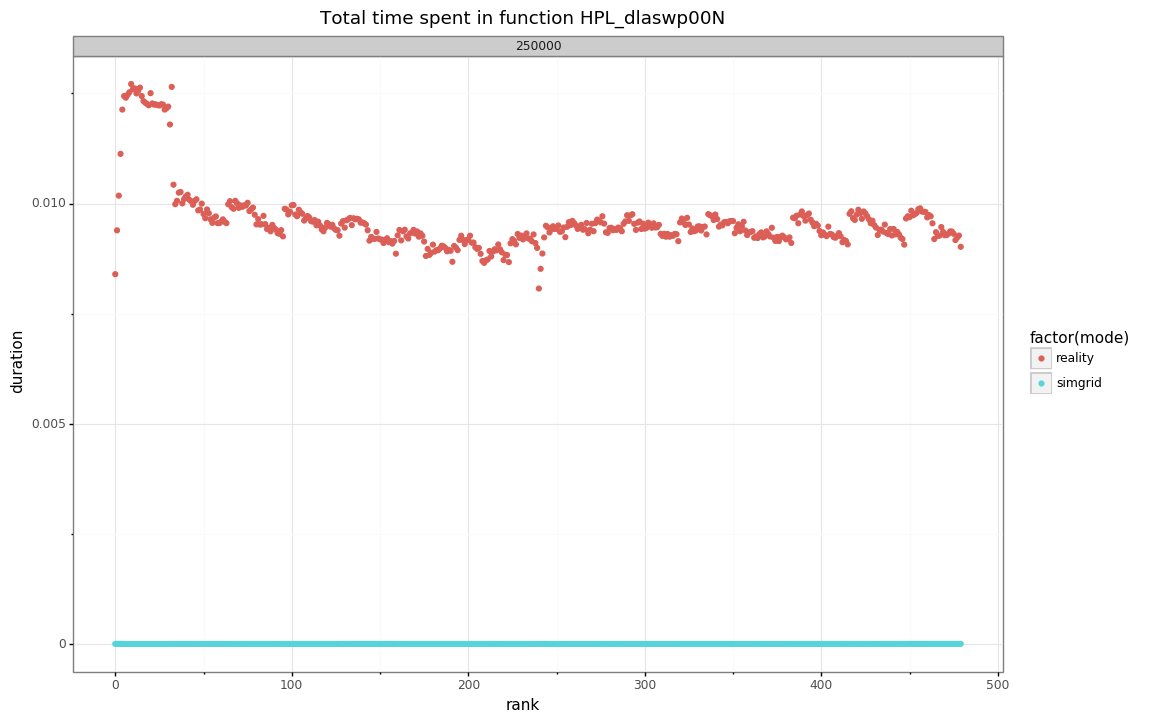

<ggplot: (8789213662819)>


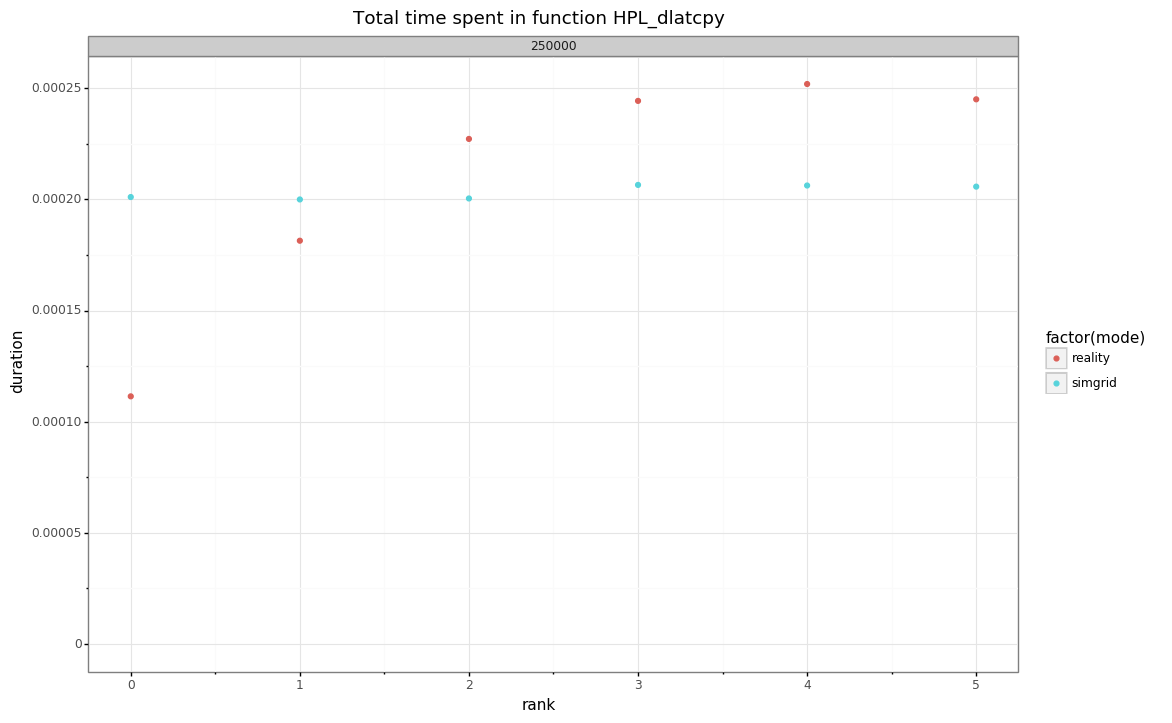

<ggplot: (-9223363247643936445)>


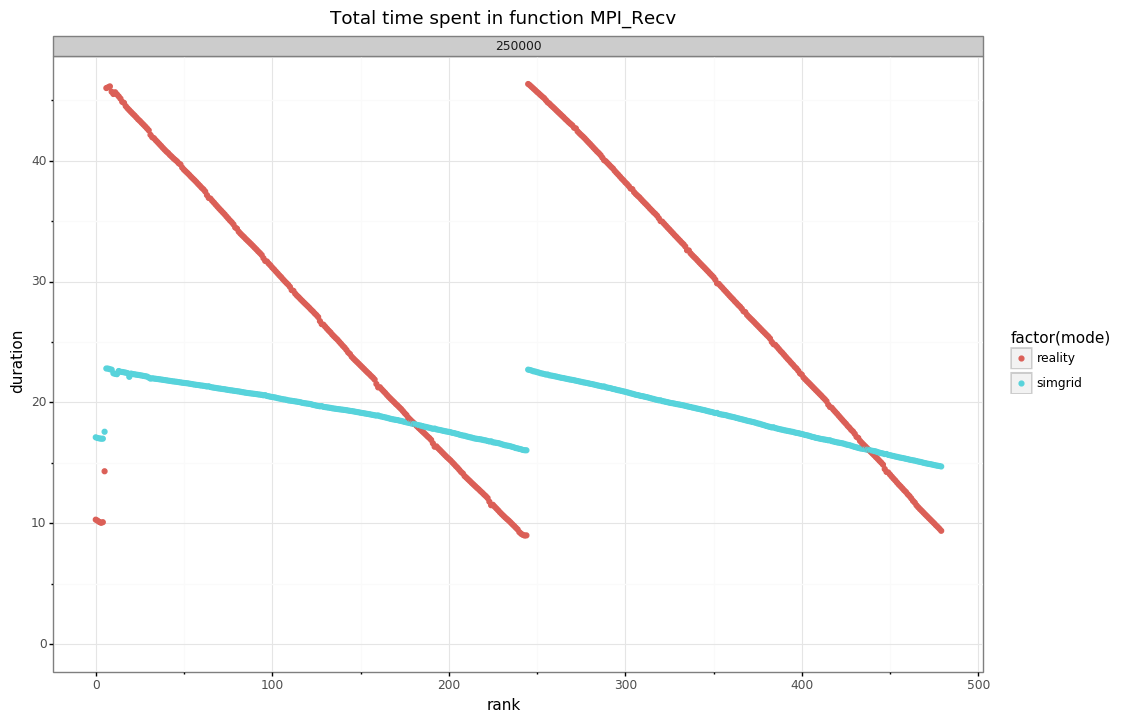

<ggplot: (8789213597851)>


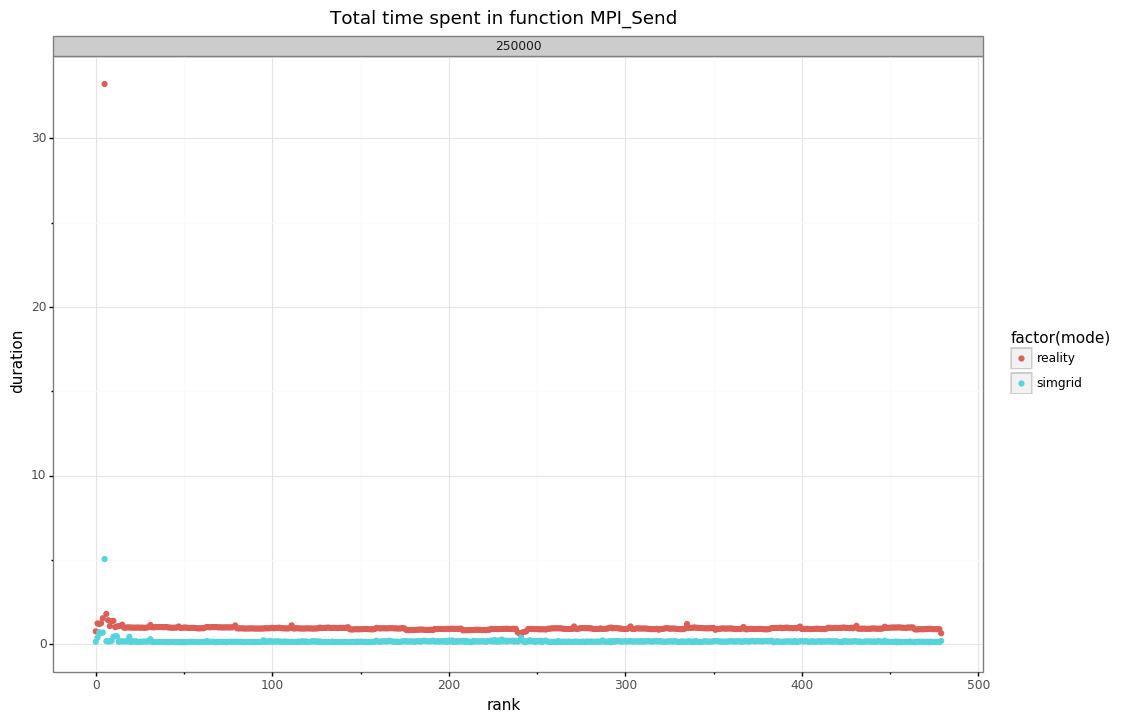

<ggplot: (-9223363247641113179)>


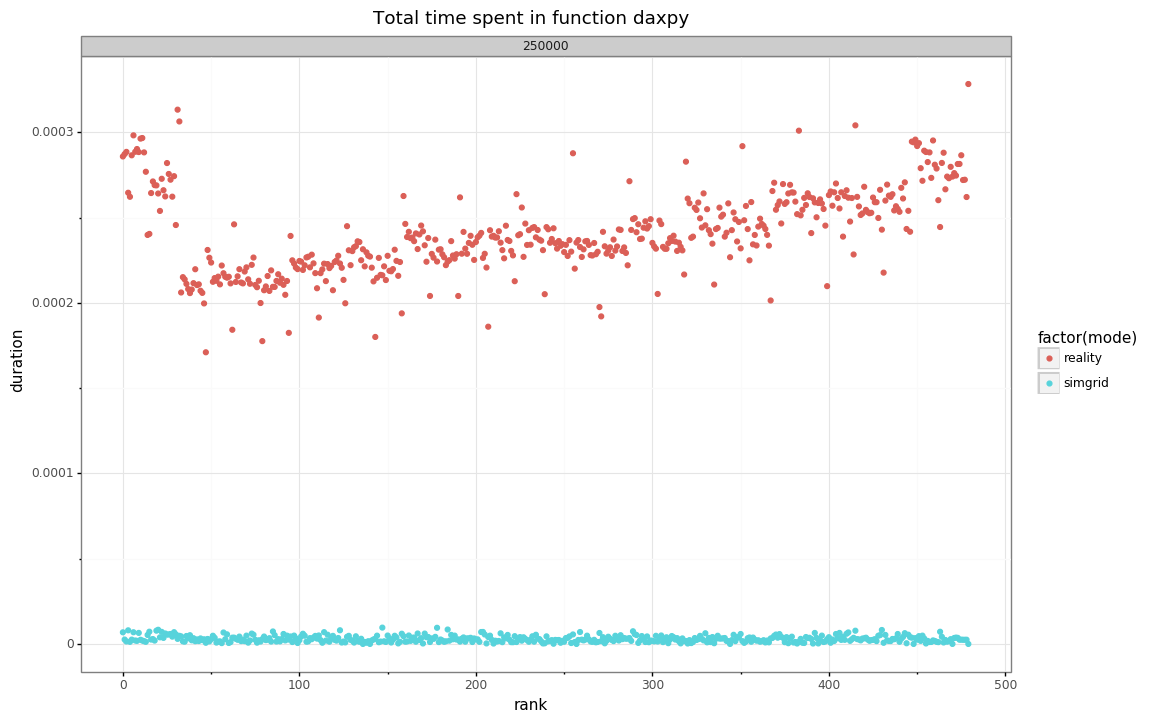

<ggplot: (8789213608221)>


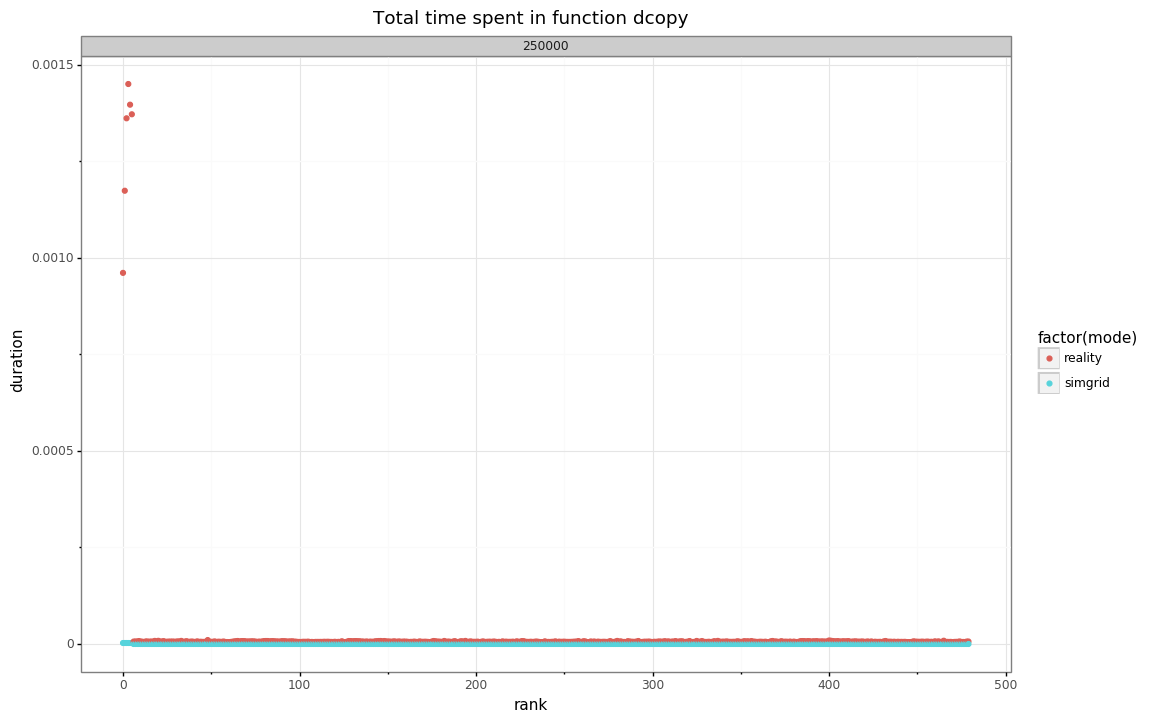

<ggplot: (-9223363247641197596)>


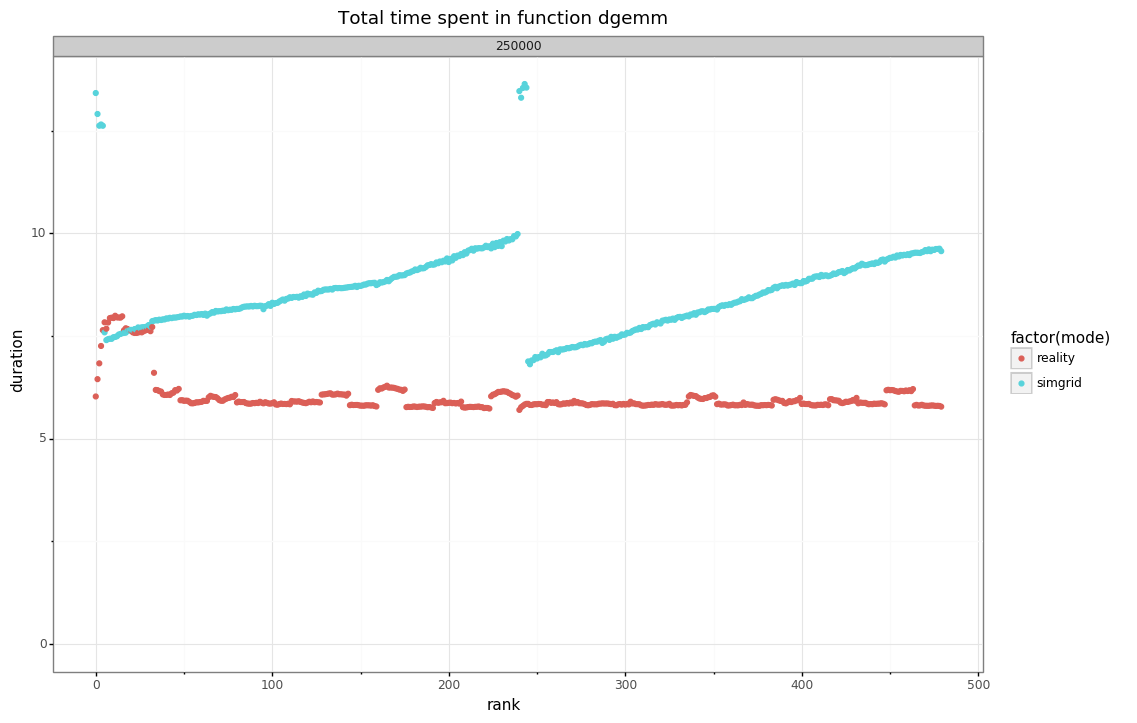

<ggplot: (8789223872502)>


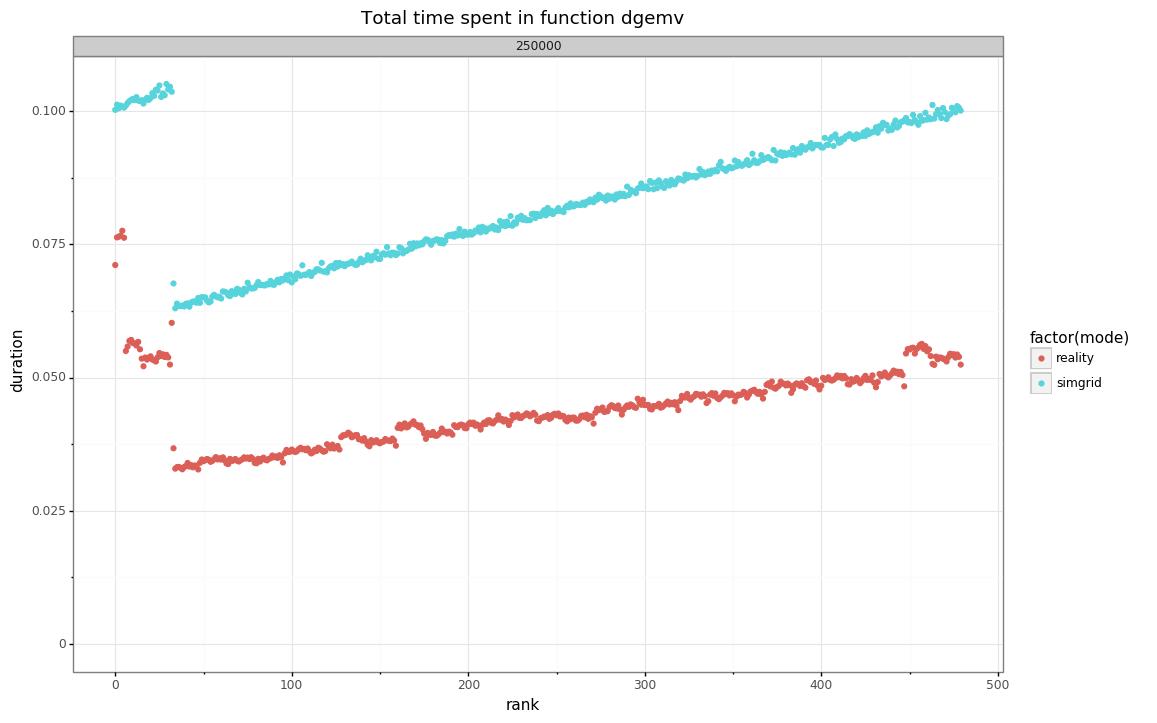

<ggplot: (8789213661360)>


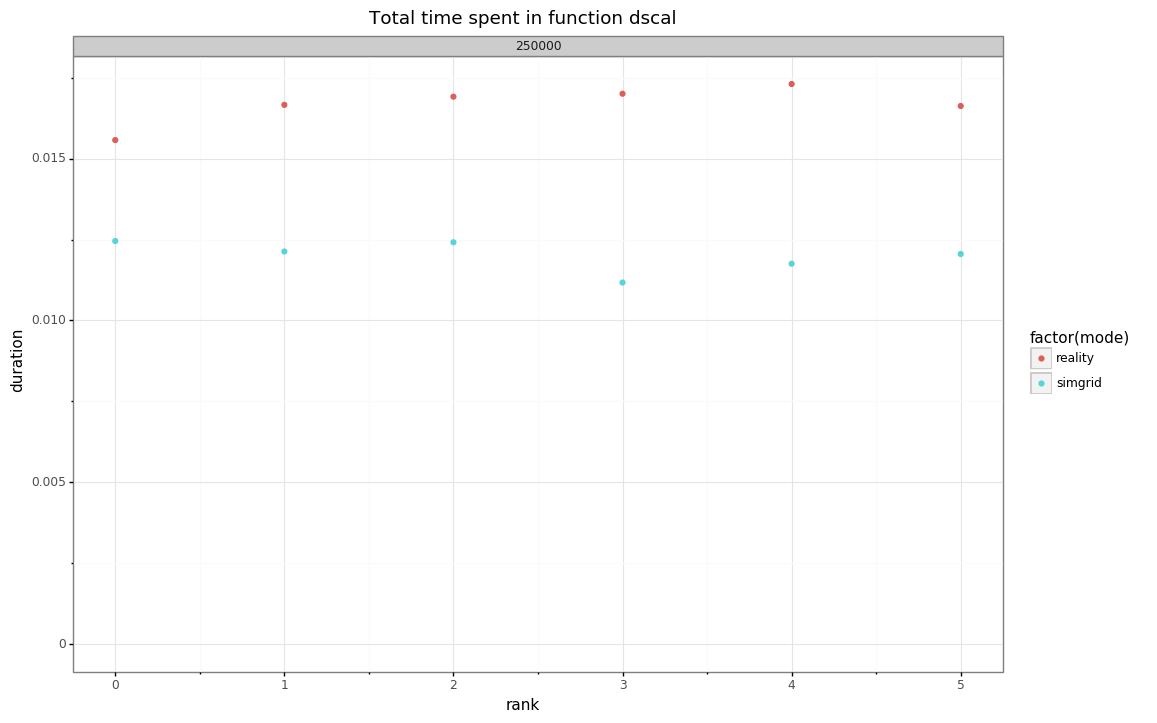

<ggplot: (-9223363247631136582)>


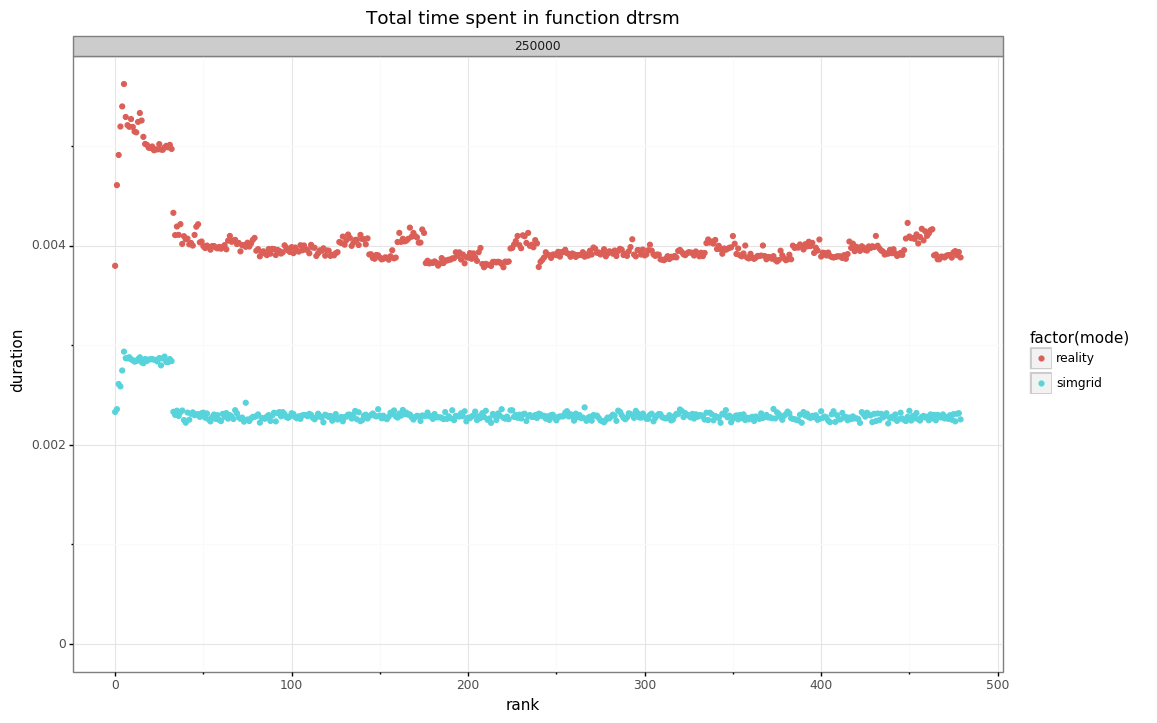

<ggplot: (8789211775082)>


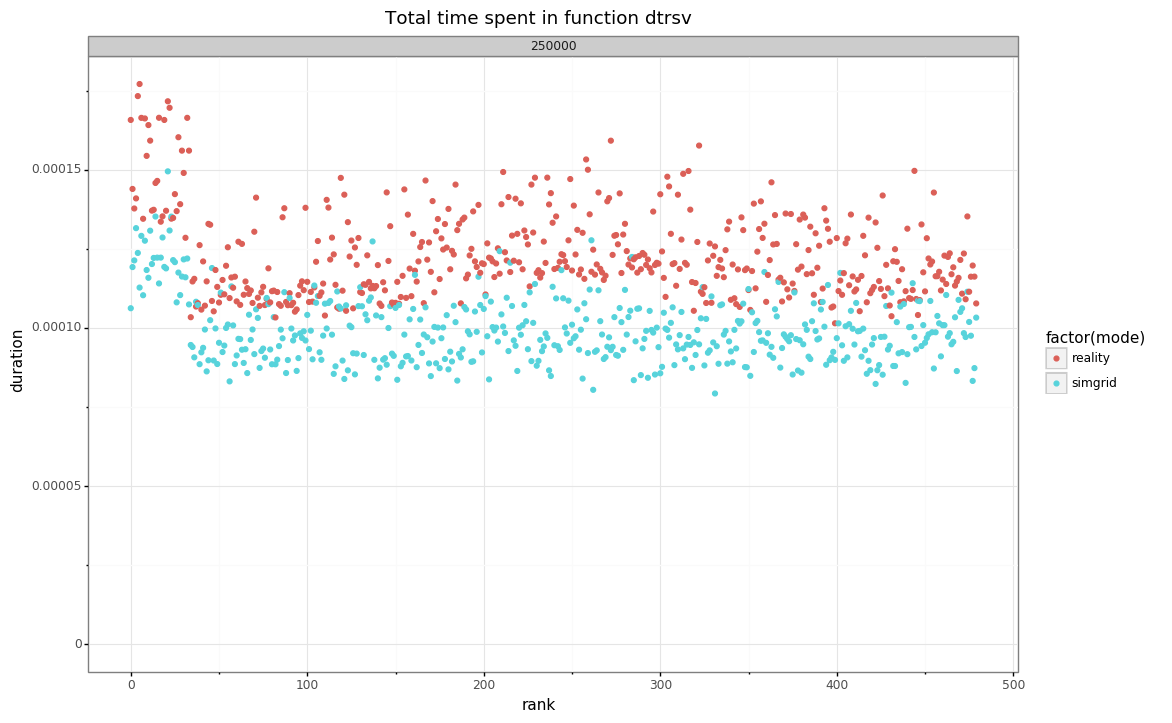

<ggplot: (8789211826703)>


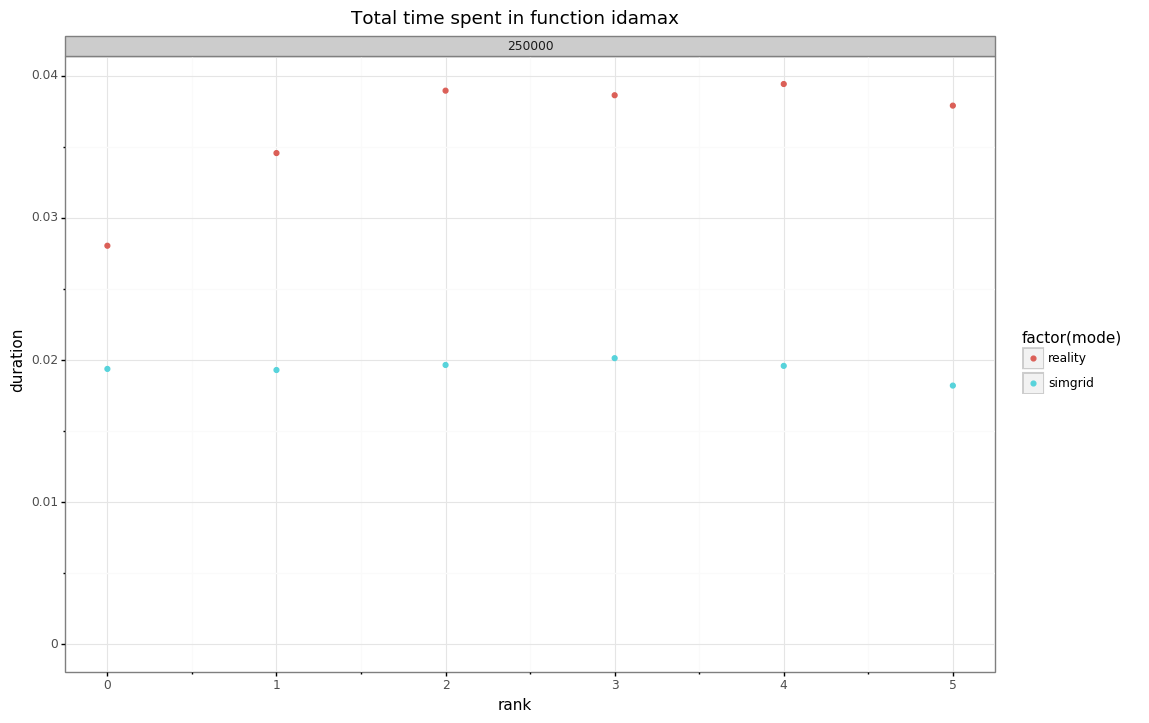

<ggplot: (8789211778175)>


In [26]:
for func in sorted(set(traces[traces['mode'].str.startswith('simgrid')].function.unique()) & set(traces[traces['mode'] == 'reality'].function.unique()) - {'MPI_Bcast', 'smpi_marker', 'MPI_Irecv'}):
    plot_total_duration(traces, func)

## Comparing the communications

In [27]:
def compute_cumsum(df, column, functions):
    dataframes = []
    for mode in df['mode'].unique():
        for function in functions:
            cols = ['start', 'end', 'function', 'mode'] + [column]
            tmp = df[(df['mode'] == mode) & (df['function'] == function)][cols].copy()
            tmp = tmp.sort_values(by=['start'])
            tmp['cumsum'] = tmp[column].cumsum()
            dataframes.append(tmp)
    return pandas.concat(dataframes)

In [28]:
tmp = traces[traces['function'].isin(['MPI_Recv', 'MPI_Send'])].copy().reset_index(drop=True)
tmp.groupby(['matrix_size', 'function', 'mode']).sum()[['msg_size', 'duration']]

msg_size      duration
matrix_size function mode                               
250000      MPI_Recv reality  735645923792  13217.887271
                     simgrid  735645923792   9189.904042
            MPI_Send reality  735645923792    478.819686
                     simgrid  735530544592     77.560062

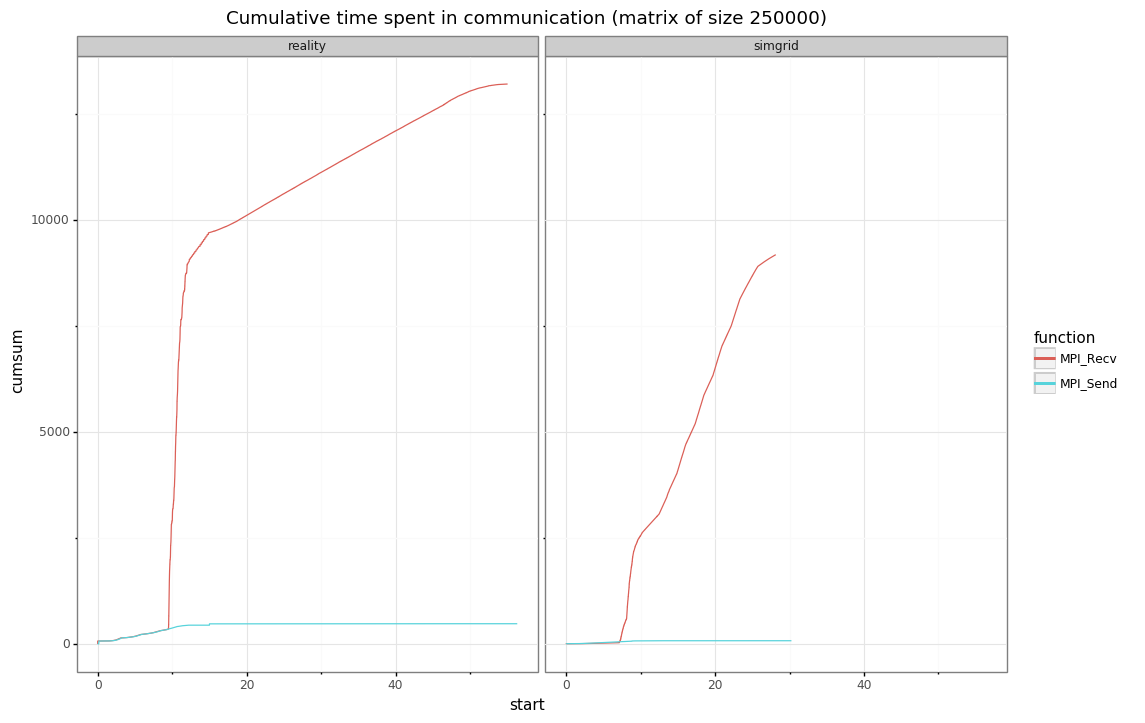

<ggplot: (8789212063394)>


In [29]:
for size in sorted(traces['matrix_size'].unique()):
    plot = ggplot(compute_cumsum(traces[traces['matrix_size'] == size], 'duration', ['MPI_Send', 'MPI_Recv', 'MPI_Irecv']), aes(x='start', y='cumsum', color='function', group='function'))
    print(plot + geom_line() + theme_bw() + facet_wrap('mode') + ggtitle('Cumulative time spent in communication (matrix of size %d)' % size))

## Comparing the computations

In [30]:
tmp = traces[traces['function'].isin(['dgemm', 'dtrsm'])].copy().reset_index(drop=True)
tmp['size_product'] = -1
tmp.loc[tmp['function'] == 'dgemm', 'size_product'] = tmp['m'] * tmp['n'] * tmp['k']
tmp.loc[tmp['function'] == 'dtrsm', 'size_product'] = tmp['m'] * tmp['n']**2

In [31]:
tmp.groupby(['matrix_size', 'function', 'mode']).sum()[['size_product', 'duration']]

size_product     duration
matrix_size function mode                              
250000      dgemm    reality  3.988947e+13  2892.843025
                     simgrid  3.988947e+13  4105.411772
            dtrsm    reality  2.069278e+10     1.933664
                     simgrid  2.061309e+10     1.113675

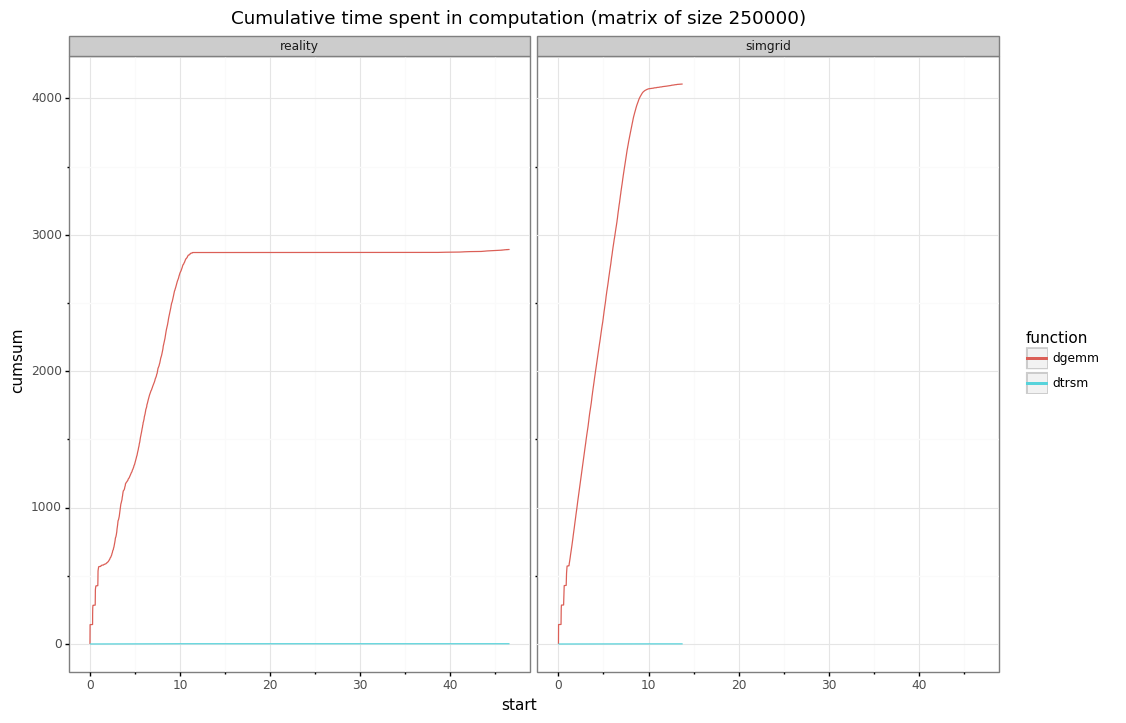

<ggplot: (8789211802551)>


In [32]:
for size in sorted(traces['matrix_size'].unique()):
    plot = ggplot(compute_cumsum(tmp[tmp['matrix_size'] == size], 'duration', ['dgemm', 'dtrsm']), aes(x='start', y='cumsum', color='function', group='function'))
    print(plot + geom_line() + theme_bw() + facet_wrap('mode') + ggtitle('Cumulative time spent in computation (matrix of size %d)' % size))

## Plotting the durations

In [33]:
blas = traces[traces['kind'] == 'BLAS'].copy().reset_index()
blas['size_product'] = -1
blas.loc[blas.function == 'dgemm', 'size_product'] = blas.m * blas.n * blas.k
blas.loc[blas.function == 'dtrsm', 'size_product'] = blas.m * blas.n**2
blas.loc[blas.function == 'dtrsv', 'size_product'] = blas.m**2
for func in ['dgemv']:
    blas.loc[blas.function == func, 'size_product'] = blas.m * blas.n
for func in ['daxpy', 'dcopy', 'dscal', 'idamax']:
    blas.loc[blas.function == func, 'size_product'] = blas.m

blas.loc[blas.function.str.startswith('HPL_'), 'size_product'] = blas.m * blas.n
for func in ['HPL_dlaswp04N', 'HPL_dlaswp04T']:
    blas.loc[blas.function == func, 'size_product'] = blas.n * blas.k
blas = blas[blas.size_product > 0].copy()

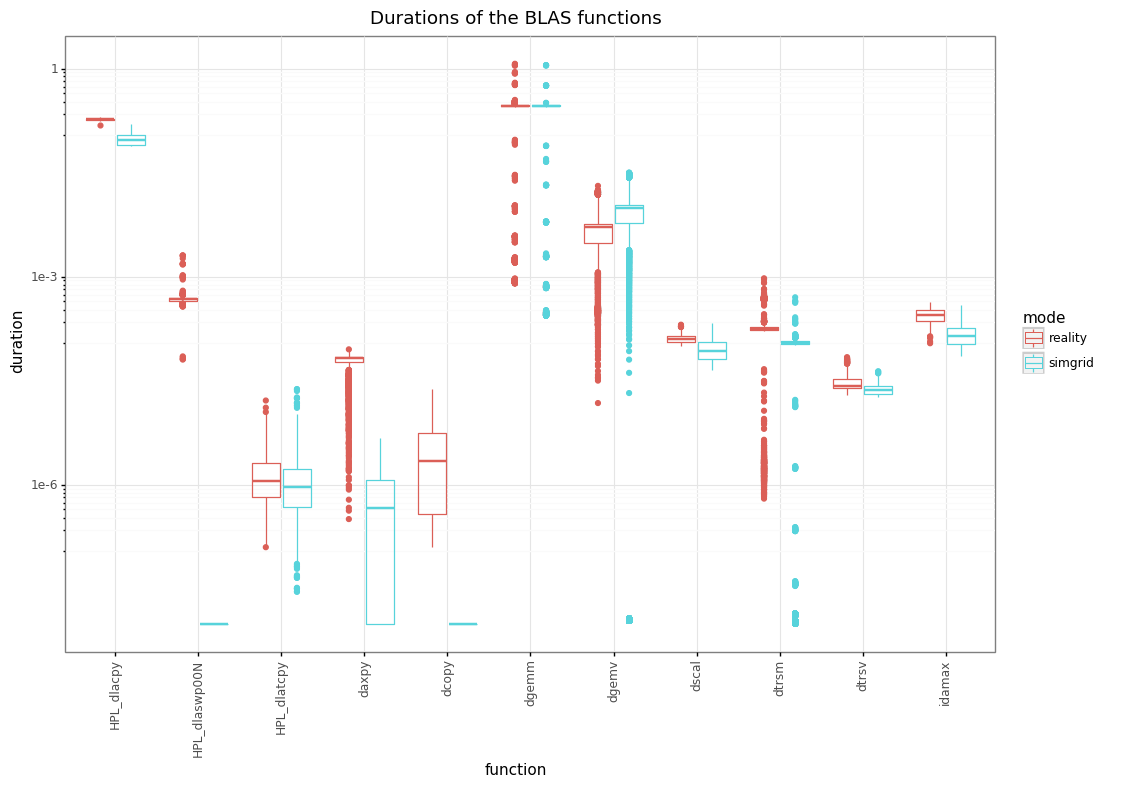

<ggplot: (-9223363247641268676)>

In [34]:
plot = ggplot(blas, aes(x='function', y='duration', color='mode')) + scale_y_log10()
plot = plot + theme_bw() + ggtitle('Durations of the BLAS functions') + geom_boxplot(alpha=0)
plot + theme(axis_text_x=element_text(rotation=90))

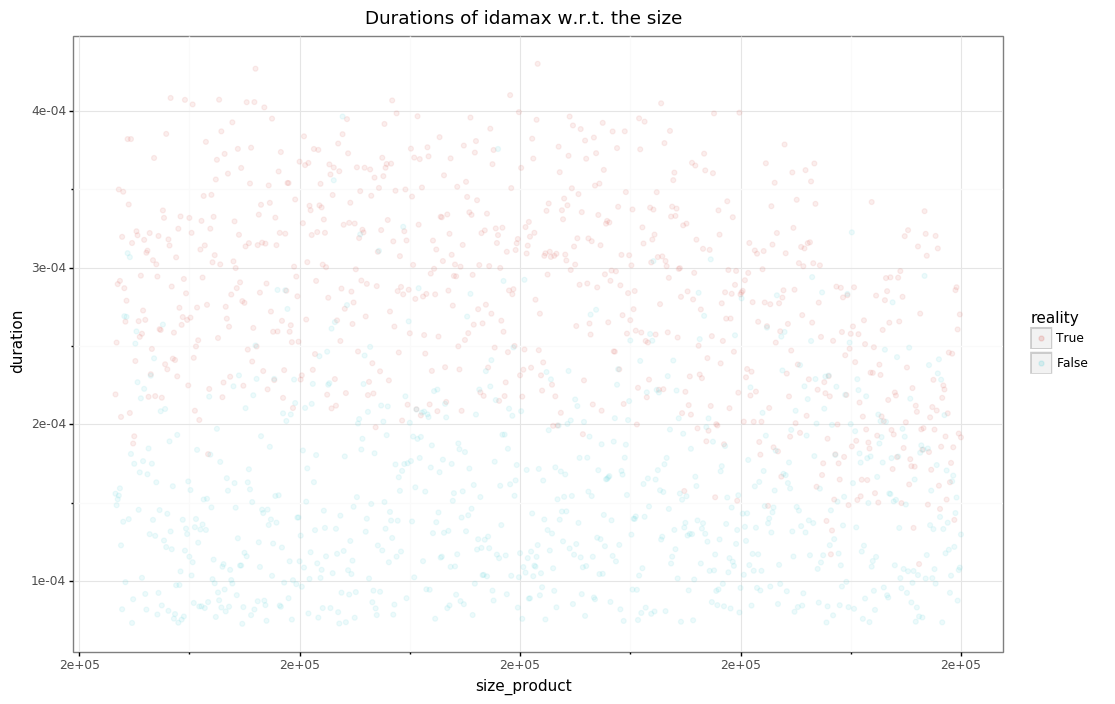

<ggplot: (-9223363247642691100)>


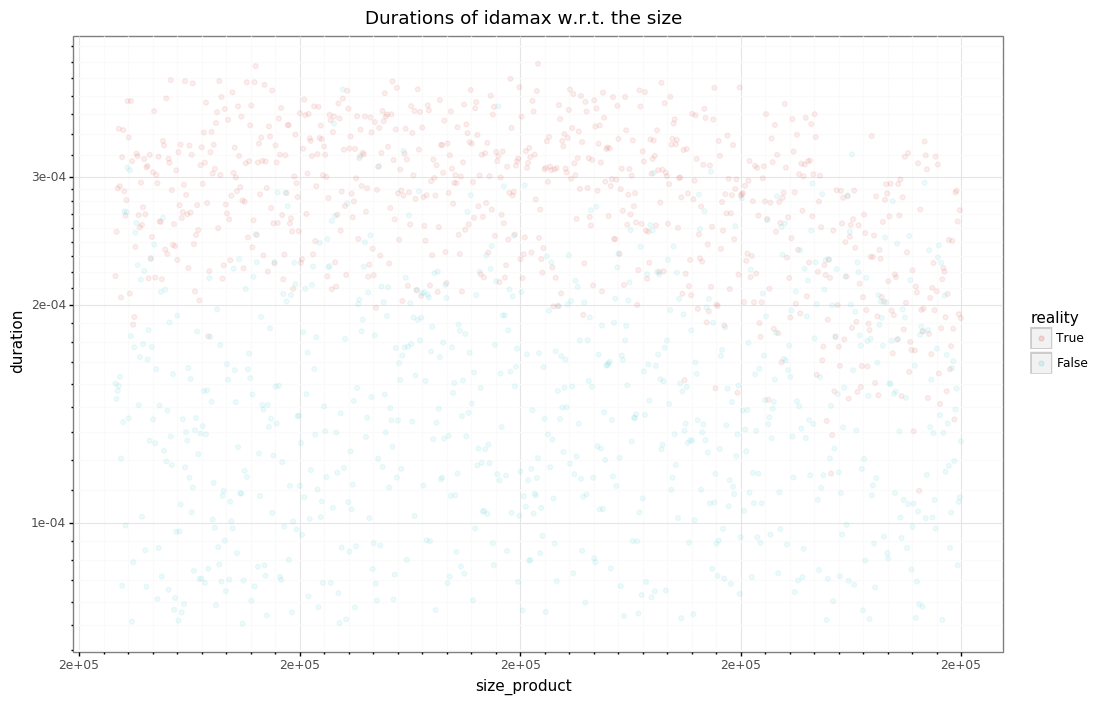

<ggplot: (-9223363247642716188)>


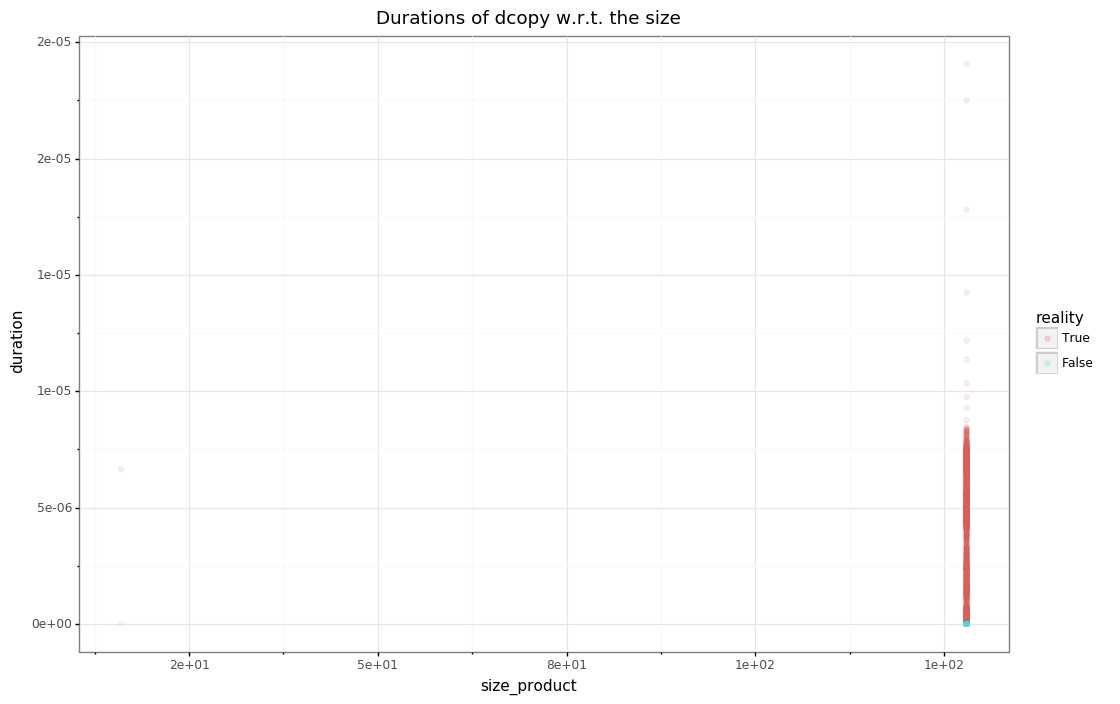

<ggplot: (-9223363247642597316)>


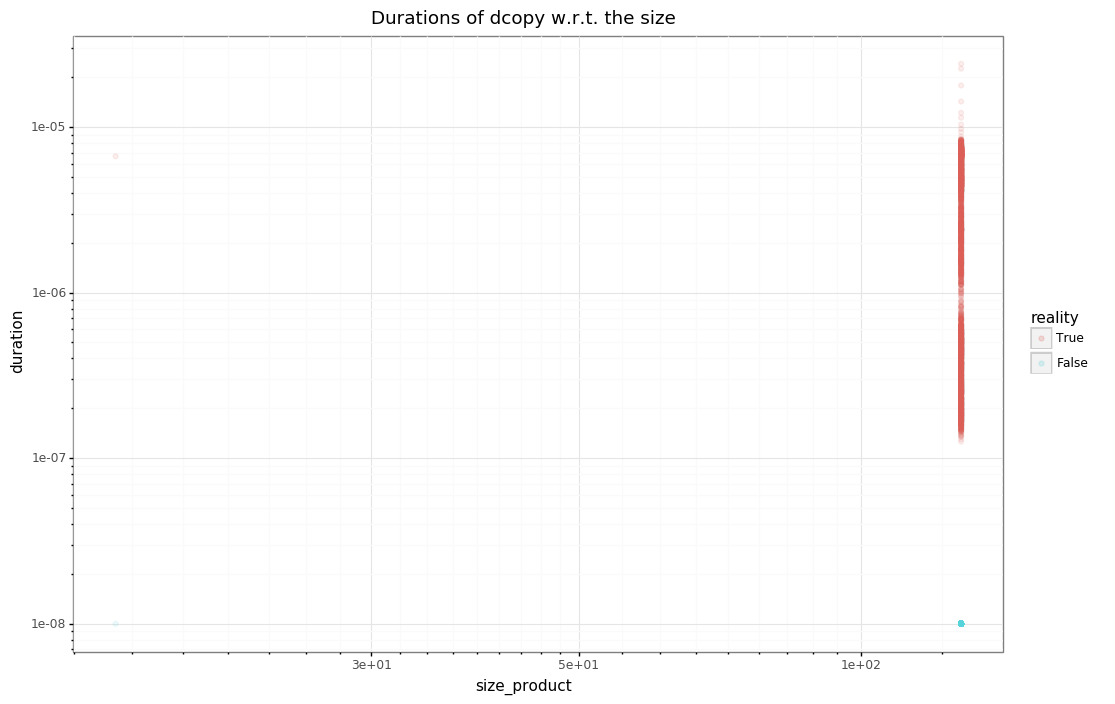

<ggplot: (-9223363247642413743)>


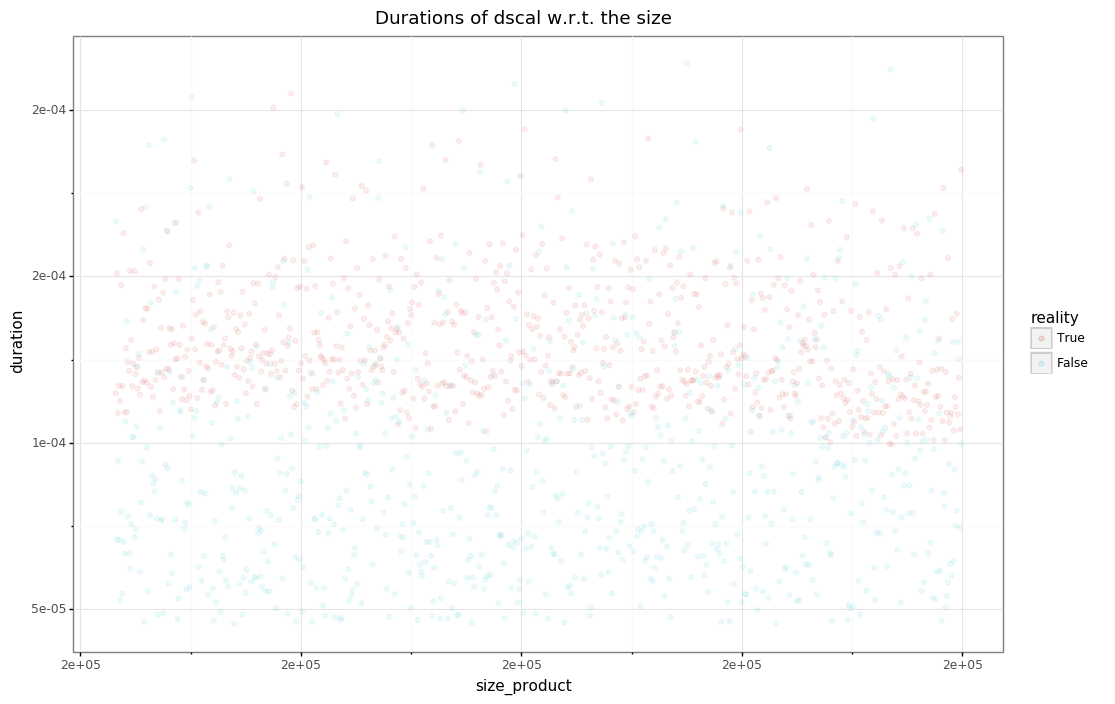

<ggplot: (8789212129719)>


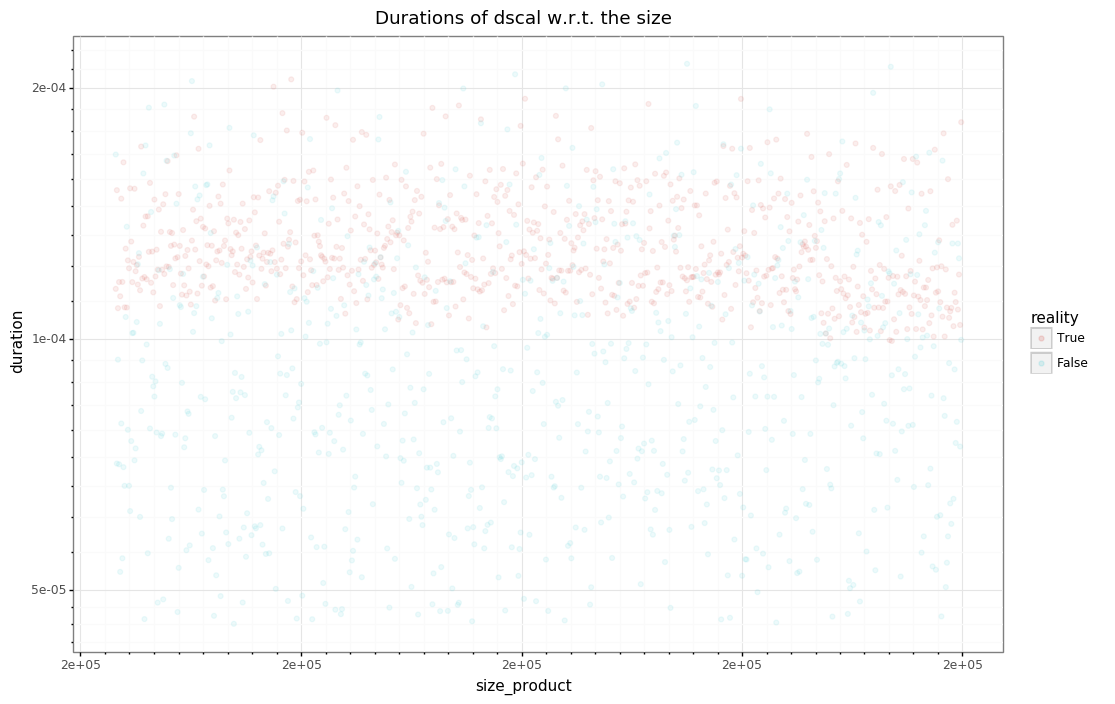

<ggplot: (-9223363247642521775)>


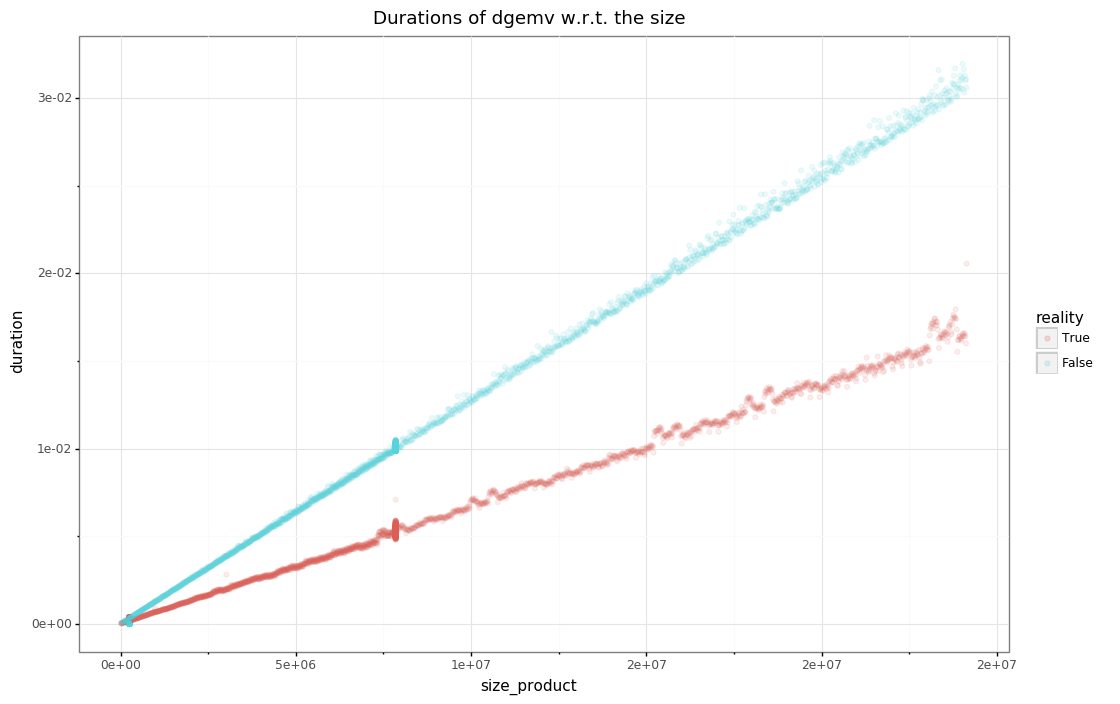

<ggplot: (8789212340712)>


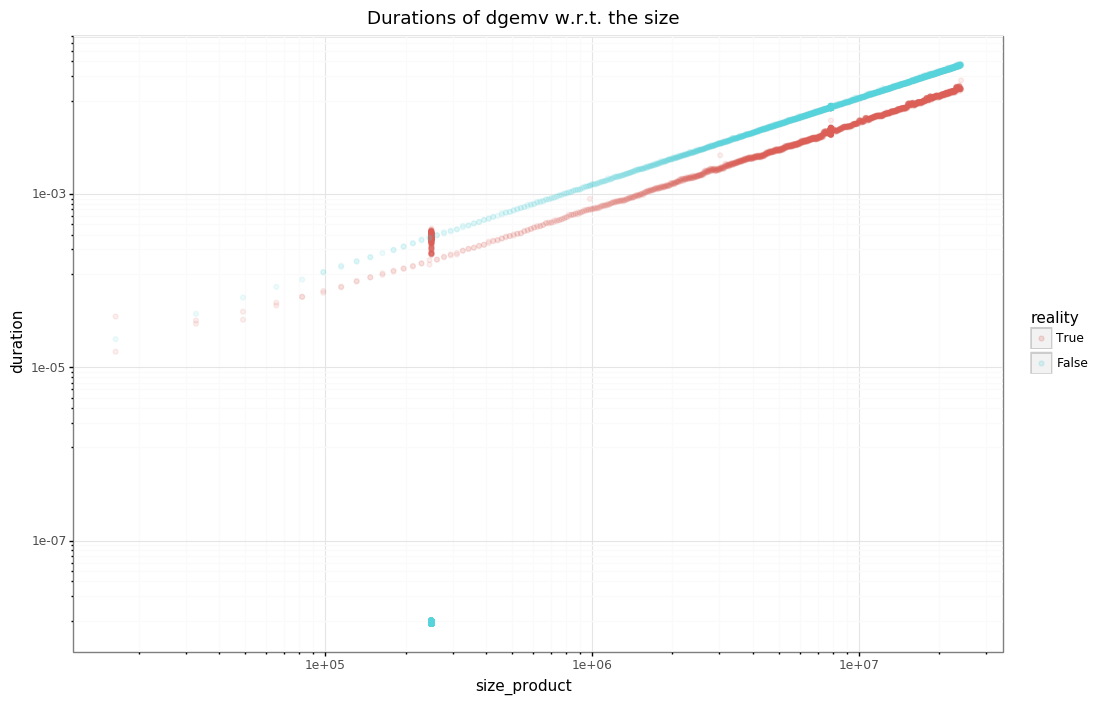

<ggplot: (8789212297501)>


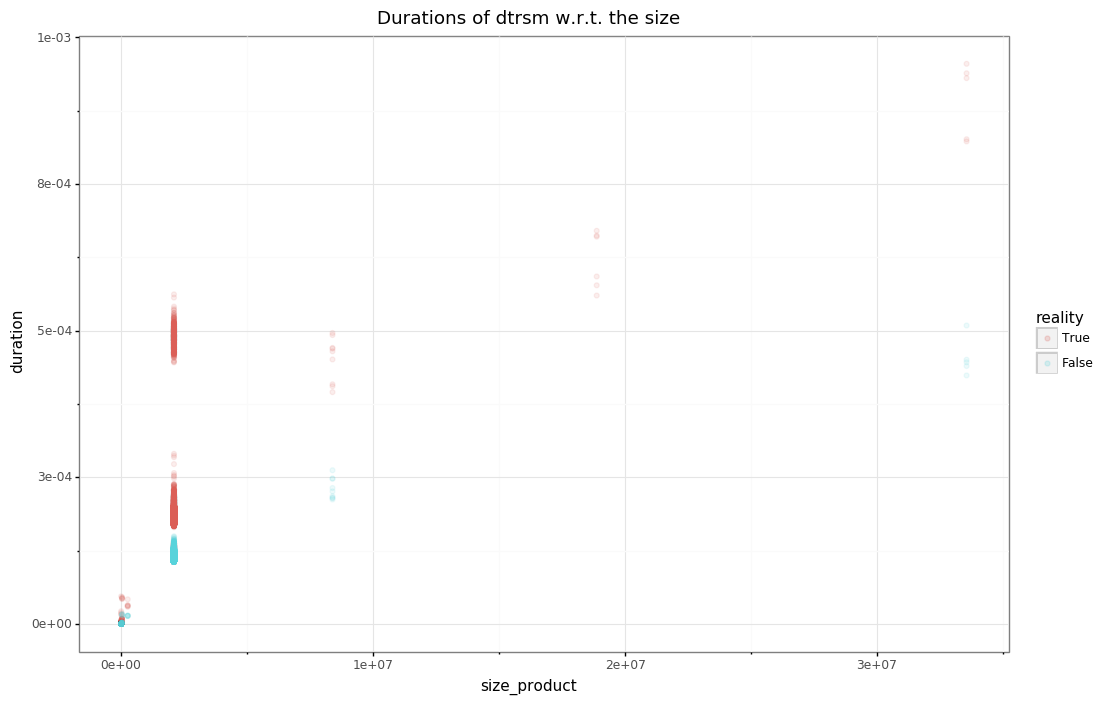

<ggplot: (8789211242216)>


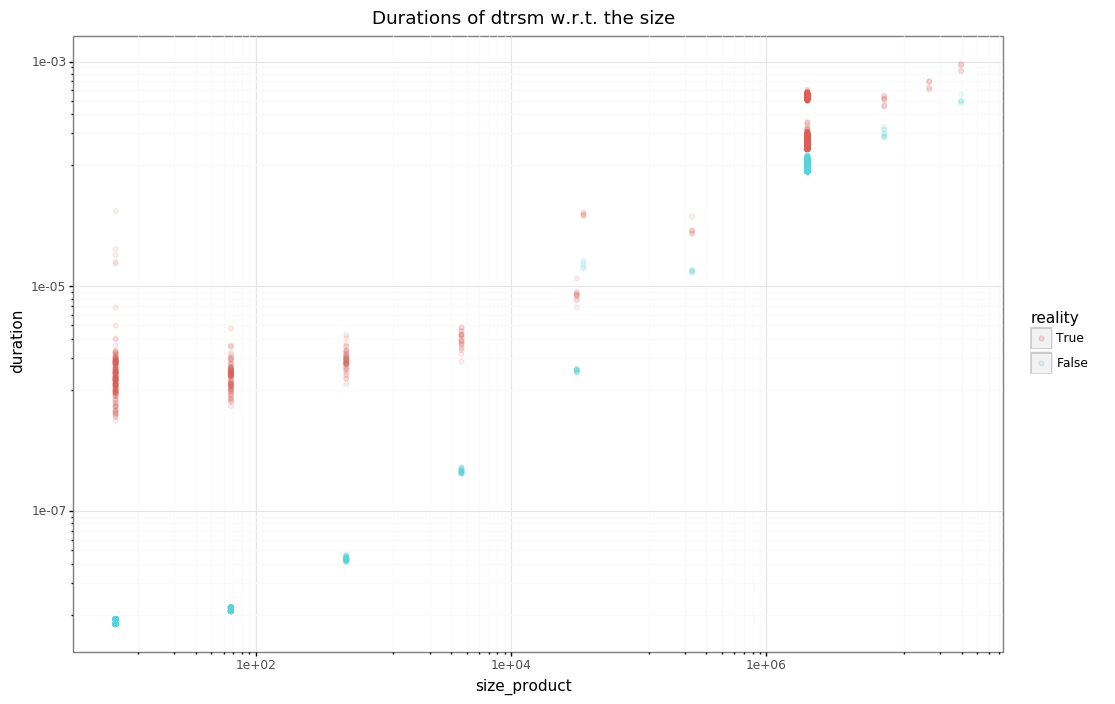

<ggplot: (8789211387449)>


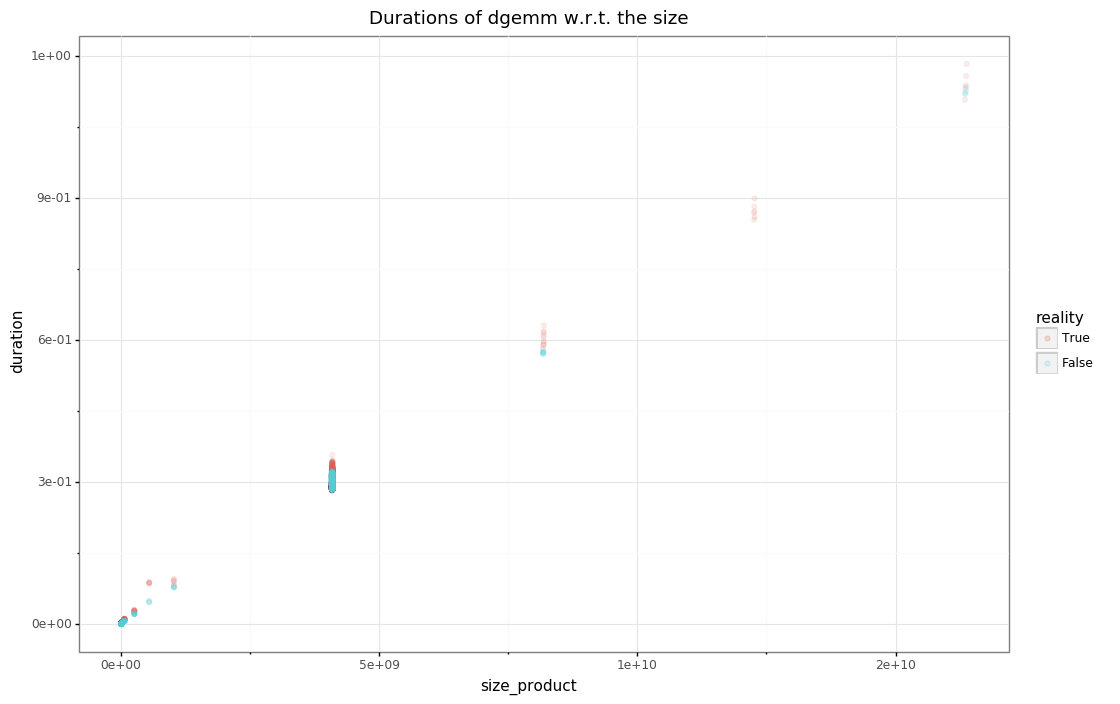

<ggplot: (8789211388287)>


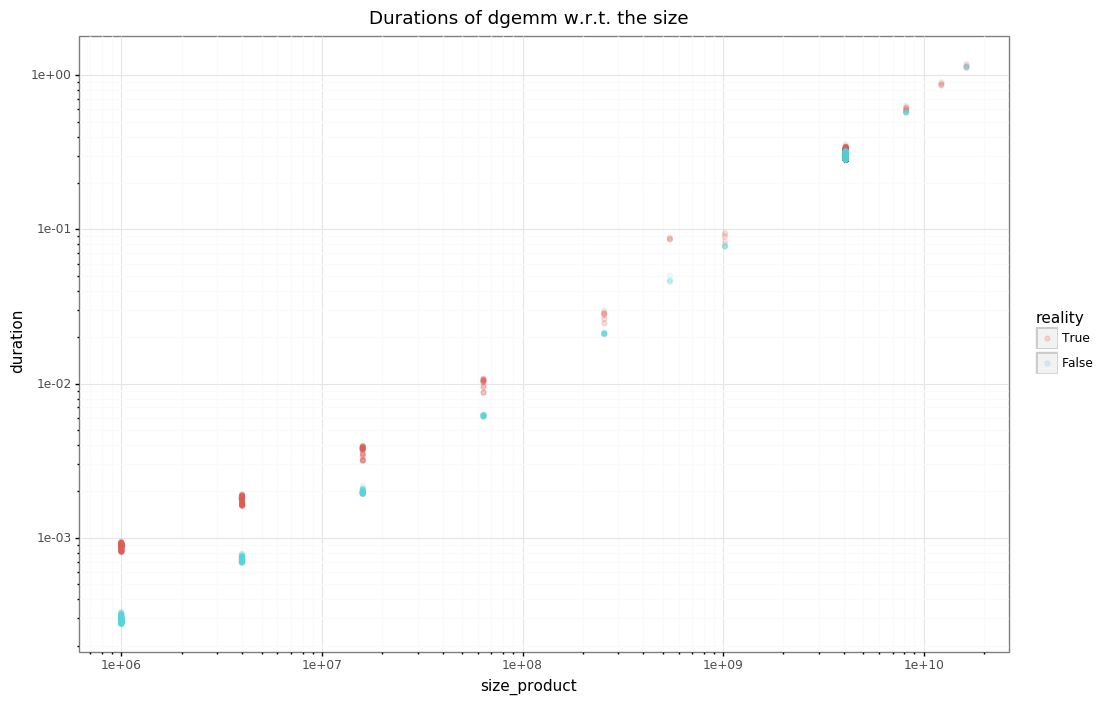

<ggplot: (-9223363247643499916)>


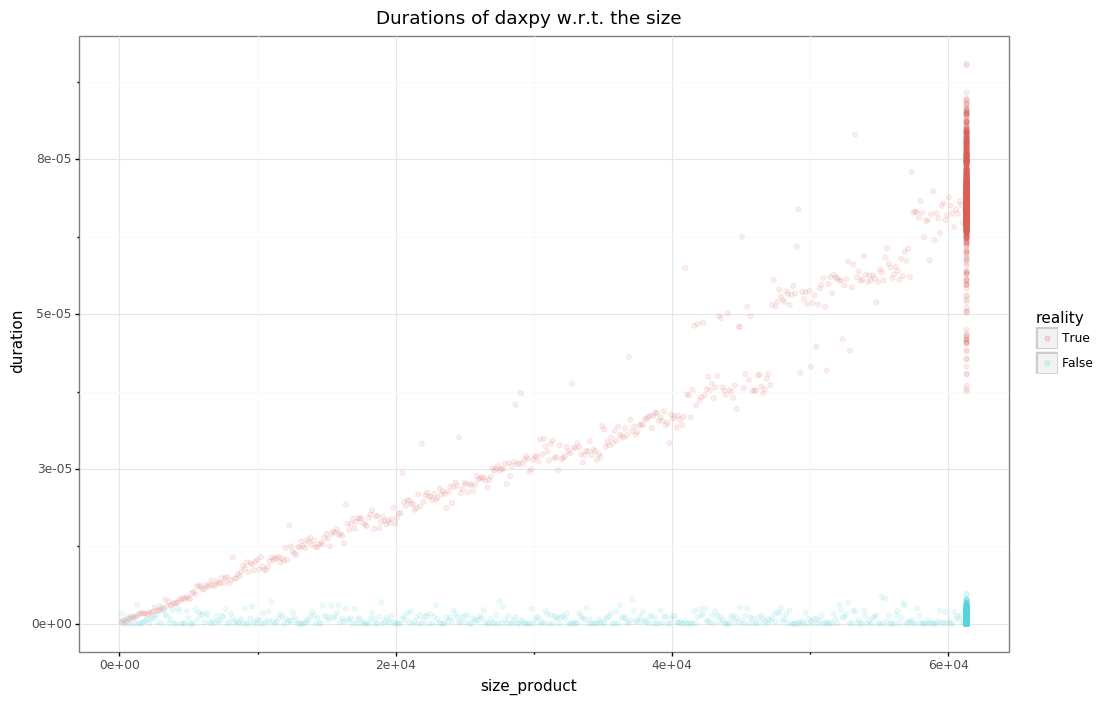

<ggplot: (-9223363247643351836)>


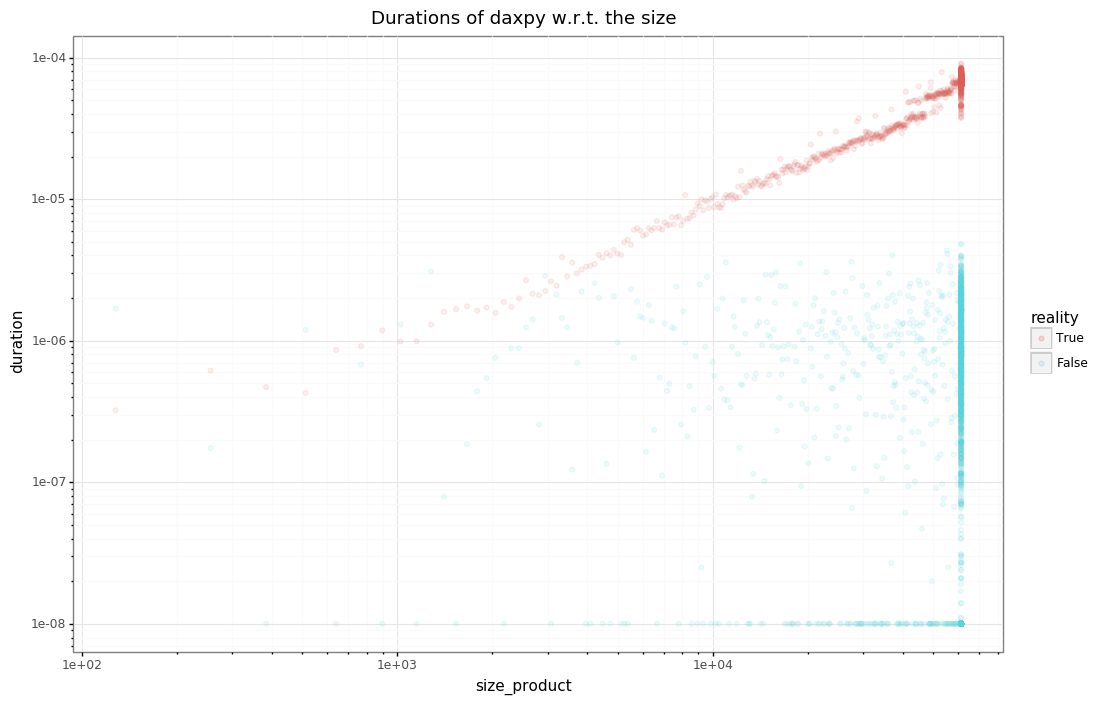

<ggplot: (8789211794219)>


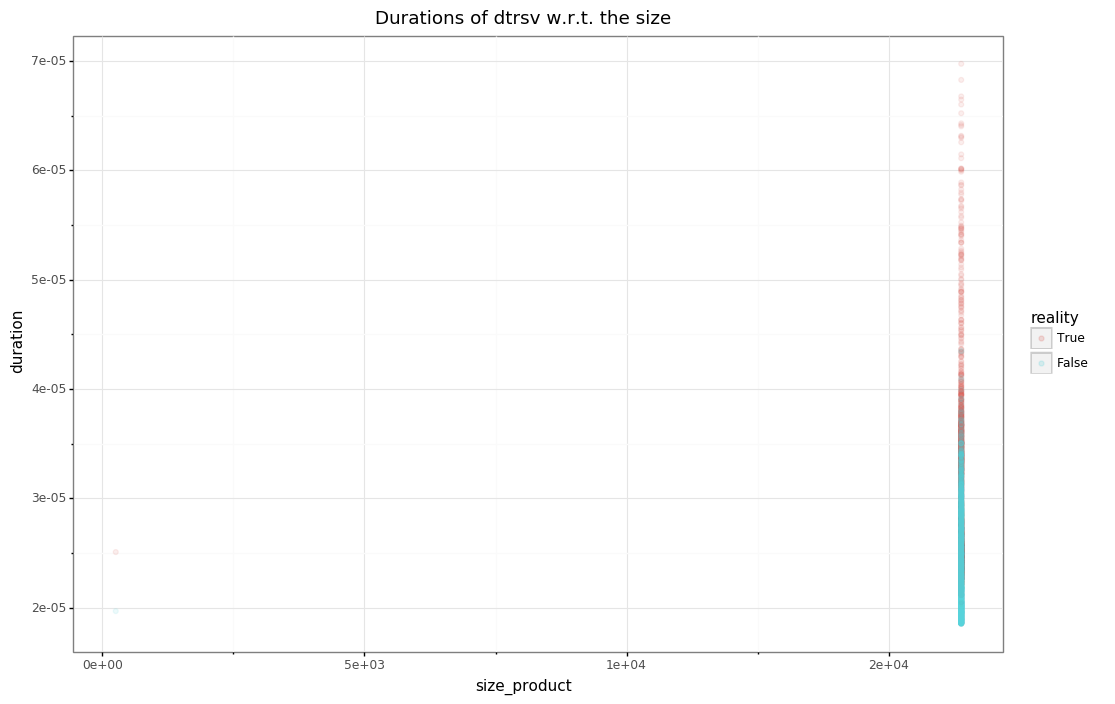

<ggplot: (8789213558767)>


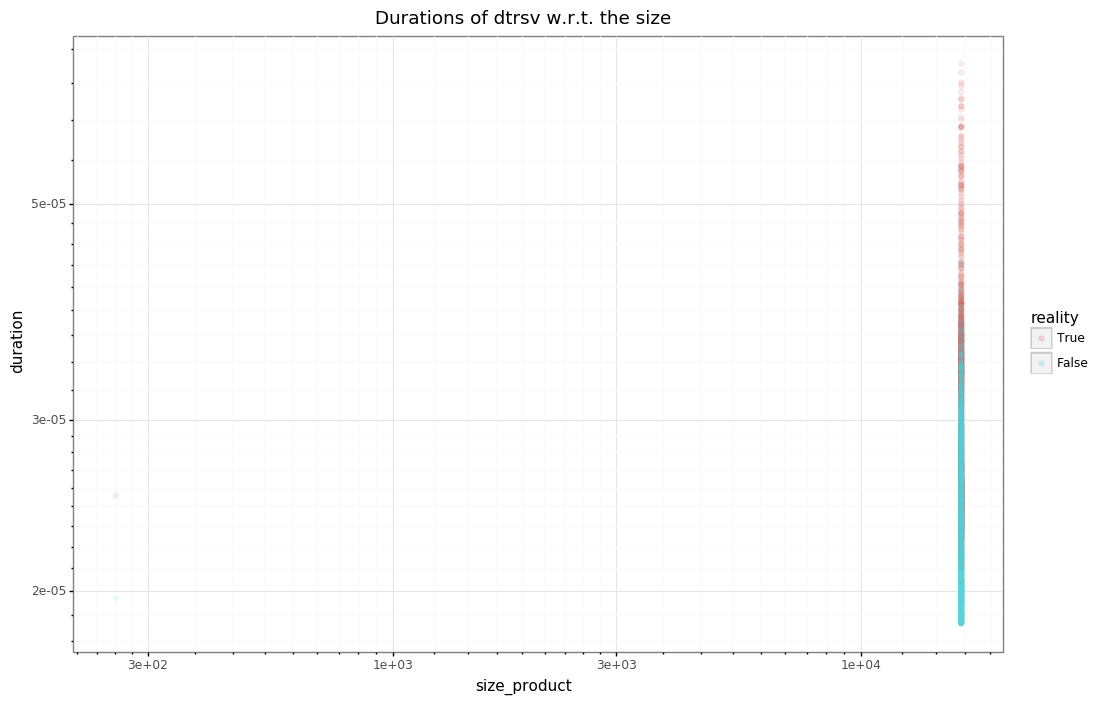

<ggplot: (8789219114672)>


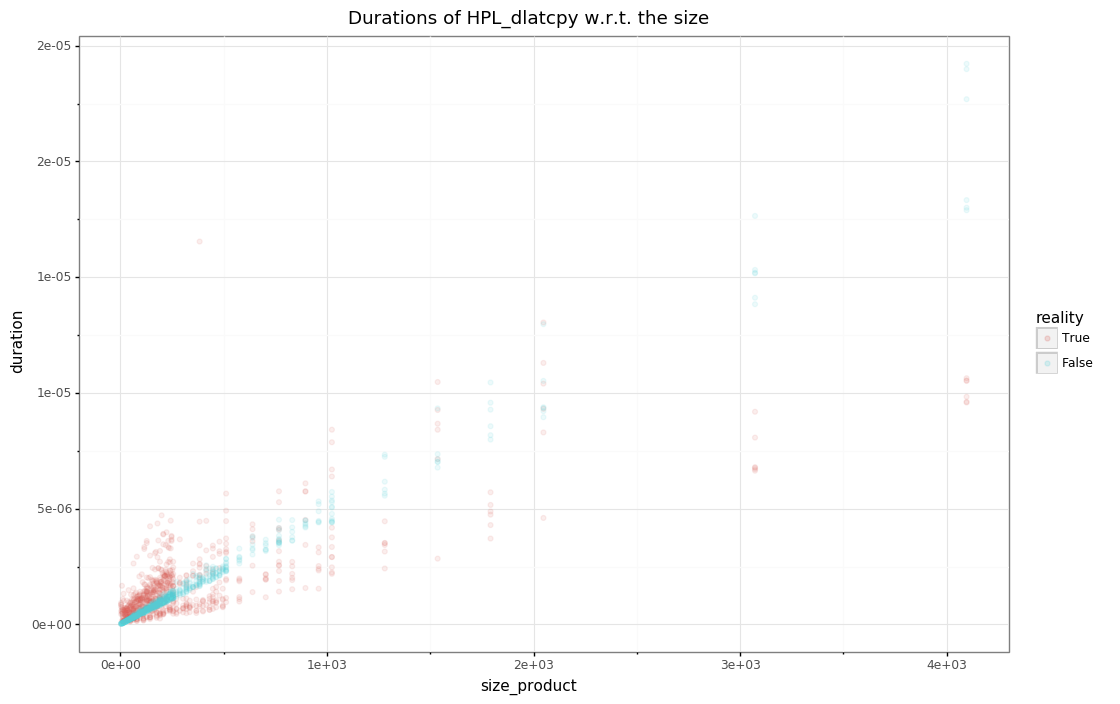

<ggplot: (-9223363247641305477)>


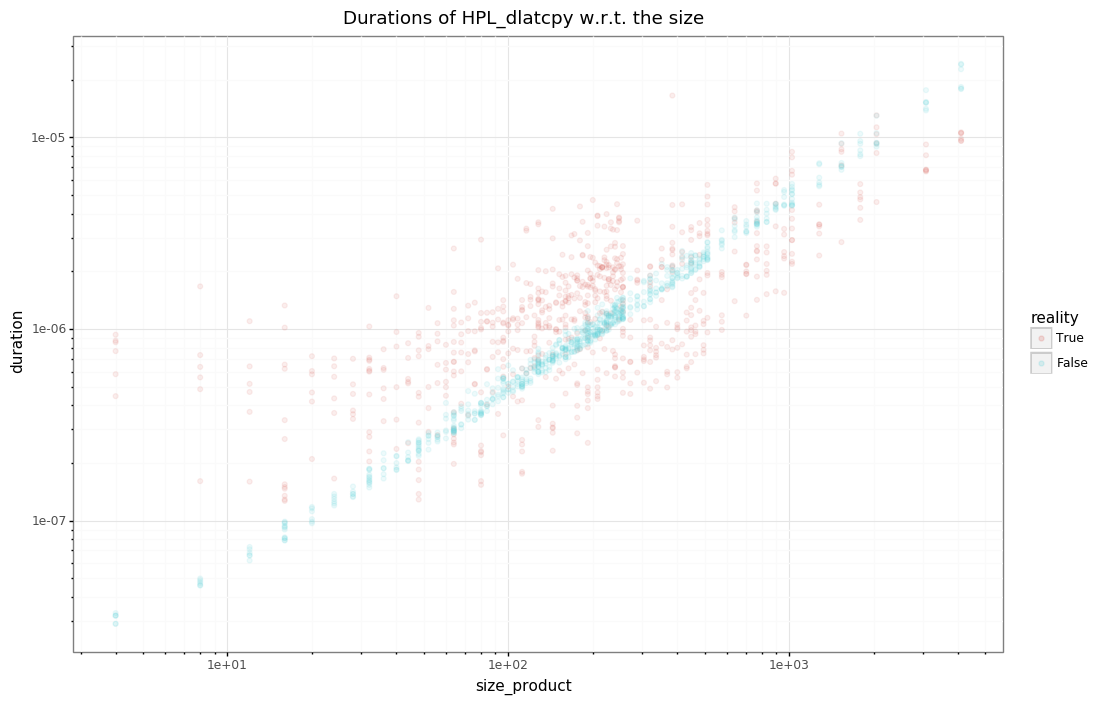

<ggplot: (8789211783877)>


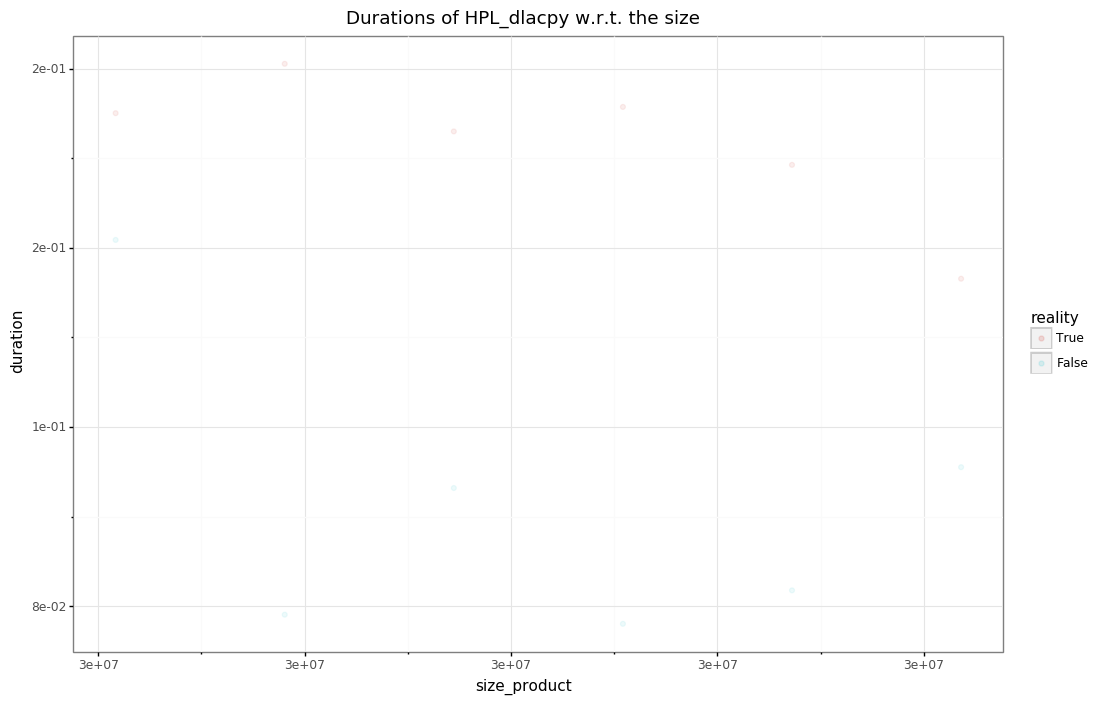

<ggplot: (-9223363247642632539)>


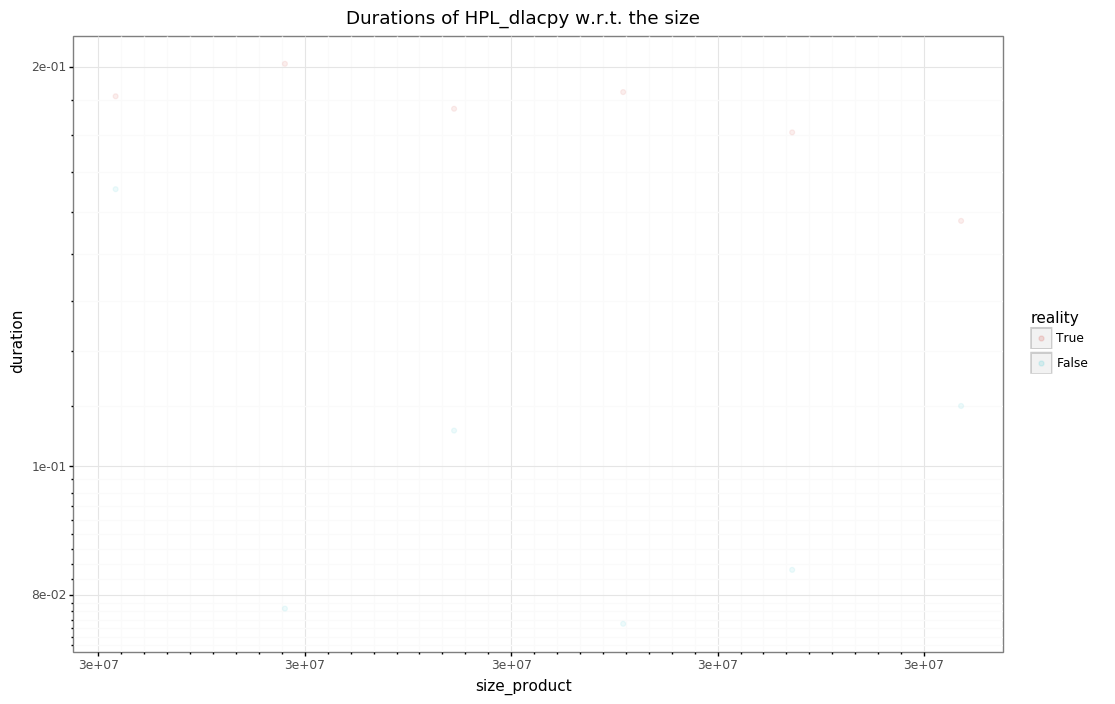

<ggplot: (-9223363247642632462)>


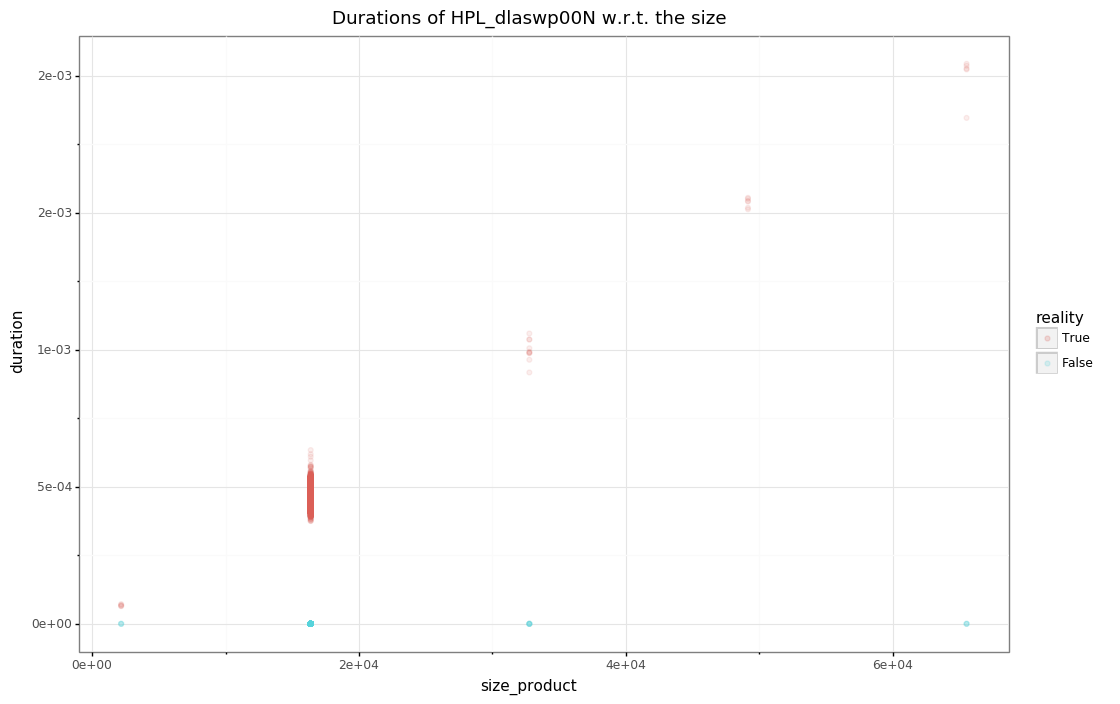

<ggplot: (-9223363247642639486)>


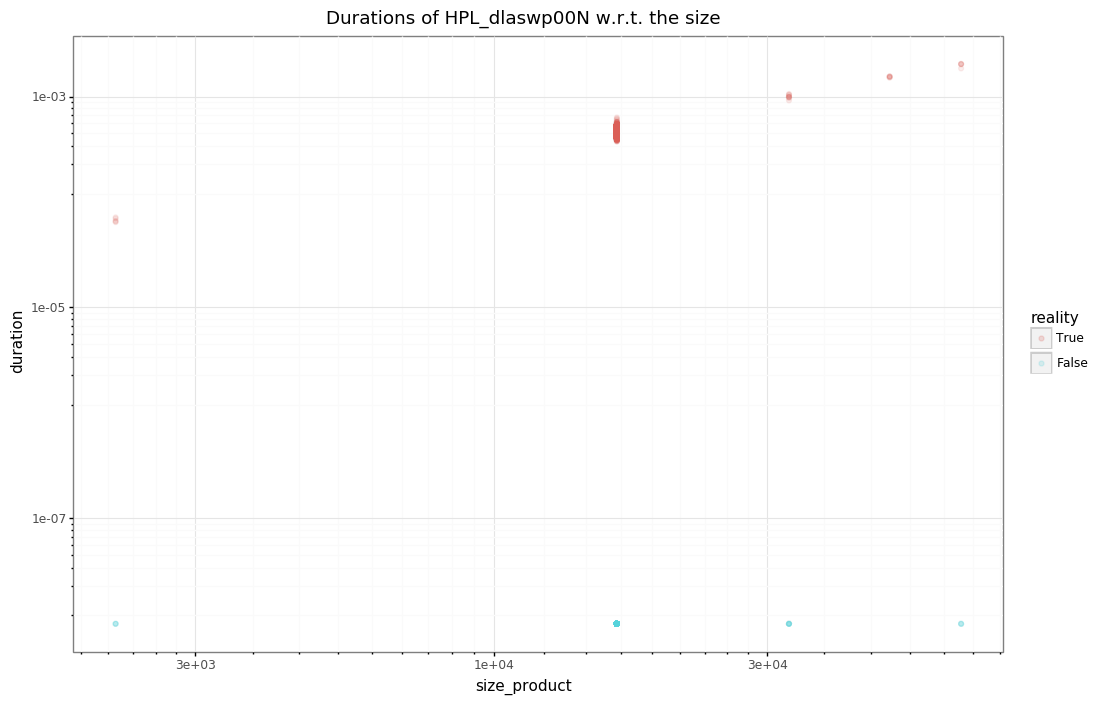

<ggplot: (-9223363247642545741)>


In [35]:
def plot_size(df, n=10000):
    func = df.function.unique()[0]
    df = df.copy()
    df['reality'] = df['mode'] == 'reality'
    df_reality = df[df.reality][['reality', 'size_product', 'duration']]
    df_sim = df[~df.reality].copy()
    try:
        df_reality = df_reality.sample(n=n)
        df_sim = df_sim.sample(n=n)
    except ValueError:  # dataframe is too small
        pass
    my_label = lambda l: ['%.0e' % x for x in l]
    plot = ggplot(aes(x='size_product', y='duration', color='reality')) + geom_point(df_reality, alpha=0.1)
    plot = plot + geom_point(df_sim, alpha=0.1) + theme_bw() + ggtitle('Durations of %s w.r.t. the size' % func)
#    plot = plot + theme(subplots_adjust={'hspace':0.15, 'wspace':0.25}) # the subplots_adjust is to fix a display bug...
    print(plot + scale_y_continuous(labels=my_label) + scale_x_continuous(labels=my_label))
    print(plot + scale_y_log10(labels=my_label) + scale_x_log10(labels=my_label))

for func in blas.function.unique():
    if not func.startswith('HPL_'):
        plot_size(blas[blas.function == func])
for func in blas.function.unique():
    if func.startswith('HPL_'):
        plot_size(blas[blas.function == func])

In [36]:
tmp = blas[blas.function.isin(['HPL_dlaswp02N', 'HPL_dlaswp03T', 'HPL_dlatcpy', 'dgemm', 'dtrsm'])][['function', 'm', 'n', 'k', 'start', 'end', 'duration', 'rank', 'mode']].copy()
tmp.loc[tmp['mode'] != 'reality', 'mode'] = 'simulation'
tmp.head()

,function,m,n,k,start,end,duration,rank,mode
9,dtrsm,2.0,2.0,NaN,0.001200,0.001247,4.681900e-05,0,reality
10,dgemm,249998.0,2.0,2.0,0.001249,0.002088,8.392390e-04,0,reality
20,HPL_dlatcpy,2.0,2.0,NaN,0.003047,0.003047,4.470000e-07,0,reality
21,dtrsm,4.0,4.0,NaN,0.003050,0.003052,1.633000e-06,0,reality
22,dgemm,249996.0,4.0,4.0,0.003053,0.004698,1.644832e-03,0,reality


In [37]:
tmp.to_csv('/tmp/trace_functions.csv', index=False)